In [1]:
from model.roberta import roberta_sum_classifier
from model.roberta import roberta_pool_classifier
from model.bert import bert_classifier
from model.xlnet import xlnet_classifier

from data.class_dataset import dataset

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sn

In [3]:
import time
import numpy as np
import pandas as pd

import torch
from torch.utils.data import ConcatDataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix

# Model

In [4]:
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [5]:
name = "bert-base-cased"
num_labels = 3
model = bert_classifier(3, name).to(DEVICE)
tokenizer = model.get_tokenizer()
loss_fn = nn.CrossEntropyLoss().to(DEVICE)
lr = 2e-5
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Dataset

In [6]:
def draw_df_label(df):
    ax = df['truth'].value_counts(sort=False).plot(kind="barh")
    ax.set_xlabel(name)
    ax.set_ylabel("Label")

In [7]:
# amazon_20201210_test_set = dataset(path="amazon5_20201210_body_test.csv", tokenizer=tokenizer, cls_token=tokenizer.cls_token)
# amazon_20201210_train_set = dataset(path="amazon5_20201210_body_train.csv", tokenizer=tokenizer, cls_token=tokenizer.cls_token)
# draw_df_label(amazon_20201210_train_set.get_df())
# amazon_20201210_train_set.get_df().head()

Size : 2210
Size : 8544


,truth,text
0,2,The Rock is destined to be the 21st Century 's...
1,2,The gorgeously elaborate continuation of `` Th...
2,2,Singer/composer Bryan Adams contributes a slew...
3,1,You 'd think by now America would have had eno...
4,2,Yet the act is still charming here .


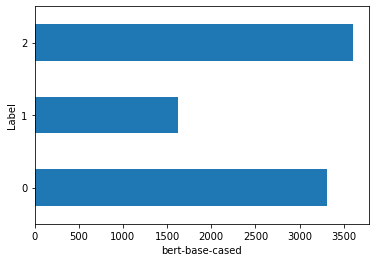

In [8]:
sst5_test_set = dataset(path='data/sst5_test.csv', tokenizer=tokenizer, cls_token=tokenizer.cls_token)
sst5_train_set = dataset(path='data/sst5_train.csv', tokenizer=tokenizer, cls_token=tokenizer.cls_token)
draw_df_label(sst5_train_set.get_df())
sst5_train_set.get_df().head()

In [9]:
# balance_set = dataset(path='amazon5_e_temp.csv', tokenizer=tokenizer, cls_token=tokenizer.cls_token)
# draw_df_label(balance_set.get_df())

In [10]:
# train_set = ConcatDataset([amazon_20201210_train_set, sst5_train_set, balance_set])
train_set = sst5_train_set
print(tokenizer.convert_ids_to_tokens(train_set.__getitem__(133)[0]))

['[CLS]', 'Miller', 'tells', 'this', 'very', 'compelling', 'tale', 'with', 'little', 'f', '##uss', 'or', 'noise', ',', 'expert', '##ly', 'p', '##luck', '##ing', 'tension', 'from', 'quiet', '.']


In [11]:
def train(loader, epochs):
    all_data = len(loader)
    for epoch in range(epochs):
        finish_data = 0
        losses = []
        current_times = []
        correct_predictions = 0
        
        for data in loader:
            t0 = time.time()
            tokens_tensors, masks_tensors, labels = [t.to(DEVICE) for t in data]

            outputs = model(input_ids=tokens_tensors,  attention_mask=masks_tensors)
            loss = loss_fn(outputs, labels.type(torch.LongTensor).to(DEVICE))
            losses.append(loss.item())
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            finish_data += 1
            current_times.append(round(time.time()-t0,3))
            current = np.mean(current_times)
            hr, min, sec = evl_time(current*(all_data-finish_data) + current*all_data*(epochs-epoch-1) + current/2*all_data*(epochs-epoch-1))
            print('epoch:', epoch, " batch:", finish_data, "/" , all_data, " loss:", np.mean(losses), " hr:", hr, " min:", min," sec:", sec)         

        save_model("train-epoch-"+name+'.pkl')
        x, y = test(loader)
        print(classification_report(x, y, target_names=[str(i) for i in range(num_labels)]))

In [12]:
def test(loader):
    pred = []
    trueth = []
    with torch.no_grad():
        for data in loader:
            tokens_tensors, masks_tensors, labels = [t.to(DEVICE) for t in data]
            outputs = model(input_ids=tokens_tensors,  attention_mask=masks_tensors)
            _, predictions = torch.max(outputs, dim=1)

            pred += list([int(i) for i in predictions])
            trueth += list([int(i) for i in labels])

    return trueth, pred

In [13]:
def load_model(path):
    model.load_state_dict(torch.load(path), strict=False)
    
def save_model(name):
    torch.save(model.state_dict(), name)

def predict(sentence, tokenizer):
    word_pieces = [tokenizer.cls_token]
    tokens = tokenizer.tokenize(sentence)
    if len(tokens) > 500:
        tokens = tokens[:200] + tokens[-300:]
    word_pieces += tokens
    ids = tokenizer.convert_tokens_to_ids(word_pieces)
    input_tensor = torch.tensor([ids]).to(self.device)

    with torch.no_grad():
        outputs = self.model(input_tensor)
        _, predictions = torch.max(outputs, dim=1)
    
    return predictions, outputs

def evl_time(t):
    min, sec= divmod(t, 60)
    hr, min = divmod(min, 60)
    return int(hr), int(min), int(sec)

def create_mini_batch(samples):
    tokens_tensors = [s[0] for s in samples]
    tokens_tensors = pad_sequence(tokens_tensors, batch_first=True)

    label_ids = torch.stack([s[1] for s in samples])
    
    masks_tensors = torch.zeros(tokens_tensors.shape, dtype=torch.long)
    masks_tensors = masks_tensors.masked_fill(tokens_tensors != 0, 1)
    
    return tokens_tensors, masks_tensors, label_ids

def draw_c_matrix(c_matrix, title="test"):
    aix = []
    for y in range(len(c_matrix)):
        aix.append(y)
    df_cm = pd.DataFrame(c_matrix, aix, aix)
    sn.heatmap(df_cm, annot=True, fmt='g')
    plt.ylabel("prediction")
    plt.xlabel("ground truth")
    plt.title(title)
    plt.savefig(title+'.jpg')
    plt.show()

# train

In [14]:
train_loader = DataLoader(train_set, batch_size=5, collate_fn=create_mini_batch, shuffle = True)

In [15]:
%time train(train_loader, 6)
save_model('3-sst5-'+name+'.pkl')

epoch: 0  batch: 1 / 1709  loss: 1.1181095838546753  hr: 1  min: 37  sec: 19
epoch: 0  batch: 2 / 1709  loss: 1.0136340856552124  hr: 0  min: 57  sec: 0
epoch: 0  batch: 3 / 1709  loss: 1.070558786392212  hr: 0  min: 44  sec: 3
epoch: 0  batch: 4 / 1709  loss: 1.1847290992736816  hr: 0  min: 37  sec: 12
epoch: 0  batch: 5 / 1709  loss: 1.2095603466033935  hr: 0  min: 32  sec: 52
epoch: 0  batch: 6 / 1709  loss: 1.1612849632898967  hr: 0  min: 29  sec: 50
epoch: 0  batch: 7 / 1709  loss: 1.2173471791403634  hr: 0  min: 27  sec: 55
epoch: 0  batch: 8 / 1709  loss: 1.22368124127388  hr: 0  min: 26  sec: 6
epoch: 0  batch: 9 / 1709  loss: 1.218246406979031  hr: 0  min: 25  sec: 3
epoch: 0  batch: 10 / 1709  loss: 1.2174855470657349  hr: 0  min: 24  sec: 5
epoch: 0  batch: 11 / 1709  loss: 1.1925246444615452  hr: 0  min: 23  sec: 13
epoch: 0  batch: 12 / 1709  loss: 1.2051039785146713  hr: 0  min: 22  sec: 28
epoch: 0  batch: 13 / 1709  loss: 1.2032702014996455  hr: 0  min: 21  sec: 51
epoc

epoch: 0  batch: 108 / 1709  loss: 1.0725142867476851  hr: 0  min: 15  sec: 38
epoch: 0  batch: 109 / 1709  loss: 1.0697765536264543  hr: 0  min: 15  sec: 37
epoch: 0  batch: 110 / 1709  loss: 1.0658161829818378  hr: 0  min: 15  sec: 36
epoch: 0  batch: 111 / 1709  loss: 1.0647879726177938  hr: 0  min: 15  sec: 37
epoch: 0  batch: 112 / 1709  loss: 1.0663460775145464  hr: 0  min: 15  sec: 36
epoch: 0  batch: 113 / 1709  loss: 1.0637331235725267  hr: 0  min: 15  sec: 35
epoch: 0  batch: 114 / 1709  loss: 1.061969781131075  hr: 0  min: 15  sec: 35
epoch: 0  batch: 115 / 1709  loss: 1.062232870640962  hr: 0  min: 15  sec: 35
epoch: 0  batch: 116 / 1709  loss: 1.0618133000258743  hr: 0  min: 15  sec: 35
epoch: 0  batch: 117 / 1709  loss: 1.0632440728000088  hr: 0  min: 15  sec: 35
epoch: 0  batch: 118 / 1709  loss: 1.0621529453891818  hr: 0  min: 15  sec: 36
epoch: 0  batch: 119 / 1709  loss: 1.0632313029104923  hr: 0  min: 15  sec: 35
epoch: 0  batch: 120 / 1709  loss: 1.0612311522165934 

epoch: 0  batch: 215 / 1709  loss: 0.9708672262901483  hr: 0  min: 15  sec: 2
epoch: 0  batch: 216 / 1709  loss: 0.969419640523416  hr: 0  min: 15  sec: 2
epoch: 0  batch: 217 / 1709  loss: 0.9699985404168406  hr: 0  min: 15  sec: 1
epoch: 0  batch: 218 / 1709  loss: 0.9689132106413535  hr: 0  min: 15  sec: 1
epoch: 0  batch: 219 / 1709  loss: 0.9714609400866783  hr: 0  min: 15  sec: 1
epoch: 0  batch: 220 / 1709  loss: 0.968207934634252  hr: 0  min: 15  sec: 1
epoch: 0  batch: 221 / 1709  loss: 0.9679081770359661  hr: 0  min: 15  sec: 0
epoch: 0  batch: 222 / 1709  loss: 0.9692310187462214  hr: 0  min: 15  sec: 0
epoch: 0  batch: 223 / 1709  loss: 0.9661612209985074  hr: 0  min: 15  sec: 0
epoch: 0  batch: 224 / 1709  loss: 0.9632425474535141  hr: 0  min: 15  sec: 0
epoch: 0  batch: 225 / 1709  loss: 0.9639639543162452  hr: 0  min: 15  sec: 0
epoch: 0  batch: 226 / 1709  loss: 0.9605912386184245  hr: 0  min: 15  sec: 0
epoch: 0  batch: 227 / 1709  loss: 0.9616573680733794  hr: 0  min:

epoch: 0  batch: 320 / 1709  loss: 0.9345010987017304  hr: 0  min: 14  sec: 49
epoch: 0  batch: 321 / 1709  loss: 0.9338917361334477  hr: 0  min: 14  sec: 49
epoch: 0  batch: 322 / 1709  loss: 0.9318483434386134  hr: 0  min: 14  sec: 49
epoch: 0  batch: 323 / 1709  loss: 0.9331753722193071  hr: 0  min: 14  sec: 49
epoch: 0  batch: 324 / 1709  loss: 0.9327367757113627  hr: 0  min: 14  sec: 49
epoch: 0  batch: 325 / 1709  loss: 0.9325987388078983  hr: 0  min: 14  sec: 49
epoch: 0  batch: 326 / 1709  loss: 0.931185831824329  hr: 0  min: 14  sec: 49
epoch: 0  batch: 327 / 1709  loss: 0.9321556708772613  hr: 0  min: 14  sec: 49
epoch: 0  batch: 328 / 1709  loss: 0.9304557470377626  hr: 0  min: 14  sec: 49
epoch: 0  batch: 329 / 1709  loss: 0.9301639993230623  hr: 0  min: 14  sec: 49
epoch: 0  batch: 330 / 1709  loss: 0.9300624719623364  hr: 0  min: 14  sec: 49
epoch: 0  batch: 331 / 1709  loss: 0.9287606322423209  hr: 0  min: 14  sec: 48
epoch: 0  batch: 332 / 1709  loss: 0.9284876311669149

epoch: 0  batch: 425 / 1709  loss: 0.8960962349176407  hr: 0  min: 14  sec: 39
epoch: 0  batch: 426 / 1709  loss: 0.8946354209747113  hr: 0  min: 14  sec: 39
epoch: 0  batch: 427 / 1709  loss: 0.8951419013654879  hr: 0  min: 14  sec: 39
epoch: 0  batch: 428 / 1709  loss: 0.8937833035869576  hr: 0  min: 14  sec: 39
epoch: 0  batch: 429 / 1709  loss: 0.8936729305760288  hr: 0  min: 14  sec: 39
epoch: 0  batch: 430 / 1709  loss: 0.8927792004028032  hr: 0  min: 14  sec: 39
epoch: 0  batch: 431 / 1709  loss: 0.8956169958665033  hr: 0  min: 14  sec: 39
epoch: 0  batch: 432 / 1709  loss: 0.8946502727835819  hr: 0  min: 14  sec: 39
epoch: 0  batch: 433 / 1709  loss: 0.8940588051741448  hr: 0  min: 14  sec: 39
epoch: 0  batch: 434 / 1709  loss: 0.8946420446312922  hr: 0  min: 14  sec: 39
epoch: 0  batch: 435 / 1709  loss: 0.8949540026229004  hr: 0  min: 14  sec: 38
epoch: 0  batch: 436 / 1709  loss: 0.894620799040849  hr: 0  min: 14  sec: 38
epoch: 0  batch: 437 / 1709  loss: 0.8931492514891264

epoch: 0  batch: 530 / 1709  loss: 0.8678187174898273  hr: 0  min: 14  sec: 31
epoch: 0  batch: 531 / 1709  loss: 0.8667965979506516  hr: 0  min: 14  sec: 31
epoch: 0  batch: 532 / 1709  loss: 0.8667791854674206  hr: 0  min: 14  sec: 31
epoch: 0  batch: 533 / 1709  loss: 0.8659999203670763  hr: 0  min: 14  sec: 31
epoch: 0  batch: 534 / 1709  loss: 0.8666933697651834  hr: 0  min: 14  sec: 31
epoch: 0  batch: 535 / 1709  loss: 0.866803098922578  hr: 0  min: 14  sec: 31
epoch: 0  batch: 536 / 1709  loss: 0.865905853099565  hr: 0  min: 14  sec: 31
epoch: 0  batch: 537 / 1709  loss: 0.8656360011693486  hr: 0  min: 14  sec: 31
epoch: 0  batch: 538 / 1709  loss: 0.8657500743588994  hr: 0  min: 14  sec: 31
epoch: 0  batch: 539 / 1709  loss: 0.8656730354108704  hr: 0  min: 14  sec: 31
epoch: 0  batch: 540 / 1709  loss: 0.8656611920230919  hr: 0  min: 14  sec: 30
epoch: 0  batch: 541 / 1709  loss: 0.8655239785169277  hr: 0  min: 14  sec: 30
epoch: 0  batch: 542 / 1709  loss: 0.8655129509163518 

epoch: 0  batch: 636 / 1709  loss: 0.862214345156959  hr: 0  min: 14  sec: 24
epoch: 0  batch: 637 / 1709  loss: 0.8619145597777149  hr: 0  min: 14  sec: 24
epoch: 0  batch: 638 / 1709  loss: 0.862343132425812  hr: 0  min: 14  sec: 24
epoch: 0  batch: 639 / 1709  loss: 0.8618215171617335  hr: 0  min: 14  sec: 24
epoch: 0  batch: 640 / 1709  loss: 0.8614896536106244  hr: 0  min: 14  sec: 24
epoch: 0  batch: 641 / 1709  loss: 0.8614550187556123  hr: 0  min: 14  sec: 24
epoch: 0  batch: 642 / 1709  loss: 0.8611282438179043  hr: 0  min: 14  sec: 24
epoch: 0  batch: 643 / 1709  loss: 0.861533952839267  hr: 0  min: 14  sec: 24
epoch: 0  batch: 644 / 1709  loss: 0.8613512494965739  hr: 0  min: 14  sec: 24
epoch: 0  batch: 645 / 1709  loss: 0.8608479935300443  hr: 0  min: 14  sec: 24
epoch: 0  batch: 646 / 1709  loss: 0.8615781319076801  hr: 0  min: 14  sec: 24
epoch: 0  batch: 647 / 1709  loss: 0.8609052398796244  hr: 0  min: 14  sec: 24
epoch: 0  batch: 648 / 1709  loss: 0.861653664022868  h

epoch: 0  batch: 741 / 1709  loss: 0.8446675199366774  hr: 0  min: 14  sec: 16
epoch: 0  batch: 742 / 1709  loss: 0.8450522091631298  hr: 0  min: 14  sec: 16
epoch: 0  batch: 743 / 1709  loss: 0.8454706792194462  hr: 0  min: 14  sec: 16
epoch: 0  batch: 744 / 1709  loss: 0.8452936480402626  hr: 0  min: 14  sec: 16
epoch: 0  batch: 745 / 1709  loss: 0.8448700028577907  hr: 0  min: 14  sec: 16
epoch: 0  batch: 746 / 1709  loss: 0.8443028334997614  hr: 0  min: 14  sec: 16
epoch: 0  batch: 747 / 1709  loss: 0.8442435366920678  hr: 0  min: 14  sec: 16
epoch: 0  batch: 748 / 1709  loss: 0.8443027813844184  hr: 0  min: 14  sec: 15
epoch: 0  batch: 749 / 1709  loss: 0.8443173962099371  hr: 0  min: 14  sec: 15
epoch: 0  batch: 750 / 1709  loss: 0.8451778377890586  hr: 0  min: 14  sec: 15
epoch: 0  batch: 751 / 1709  loss: 0.8457788752215839  hr: 0  min: 14  sec: 15
epoch: 0  batch: 752 / 1709  loss: 0.8456500789467641  hr: 0  min: 14  sec: 15
epoch: 0  batch: 753 / 1709  loss: 0.845368369503483

epoch: 0  batch: 847 / 1709  loss: 0.8292038626573021  hr: 0  min: 14  sec: 8
epoch: 0  batch: 848 / 1709  loss: 0.8296452084608938  hr: 0  min: 14  sec: 8
epoch: 0  batch: 849 / 1709  loss: 0.8296721439426864  hr: 0  min: 14  sec: 8
epoch: 0  batch: 850 / 1709  loss: 0.8292674093824975  hr: 0  min: 14  sec: 8
epoch: 0  batch: 851 / 1709  loss: 0.8286492921648378  hr: 0  min: 14  sec: 8
epoch: 0  batch: 852 / 1709  loss: 0.8282107173294668  hr: 0  min: 14  sec: 8
epoch: 0  batch: 853 / 1709  loss: 0.8277860400283322  hr: 0  min: 14  sec: 8
epoch: 0  batch: 854 / 1709  loss: 0.827088183145403  hr: 0  min: 14  sec: 8
epoch: 0  batch: 855 / 1709  loss: 0.8267283642588303  hr: 0  min: 14  sec: 8
epoch: 0  batch: 856 / 1709  loss: 0.8264327529104096  hr: 0  min: 14  sec: 8
epoch: 0  batch: 857 / 1709  loss: 0.8268961176936935  hr: 0  min: 14  sec: 8
epoch: 0  batch: 858 / 1709  loss: 0.8266219354401796  hr: 0  min: 14  sec: 8
epoch: 0  batch: 859 / 1709  loss: 0.8266791776343052  hr: 0  min

epoch: 0  batch: 954 / 1709  loss: 0.8135220425386973  hr: 0  min: 14  sec: 2
epoch: 0  batch: 955 / 1709  loss: 0.8139929275316093  hr: 0  min: 14  sec: 2
epoch: 0  batch: 956 / 1709  loss: 0.8140306150517329  hr: 0  min: 14  sec: 2
epoch: 0  batch: 957 / 1709  loss: 0.8135804682892194  hr: 0  min: 14  sec: 2
epoch: 0  batch: 958 / 1709  loss: 0.8138688572591057  hr: 0  min: 14  sec: 2
epoch: 0  batch: 959 / 1709  loss: 0.813803209883391  hr: 0  min: 14  sec: 2
epoch: 0  batch: 960 / 1709  loss: 0.8141055720625445  hr: 0  min: 14  sec: 2
epoch: 0  batch: 961 / 1709  loss: 0.8138844240670026  hr: 0  min: 14  sec: 2
epoch: 0  batch: 962 / 1709  loss: 0.8139873504592202  hr: 0  min: 14  sec: 2
epoch: 0  batch: 963 / 1709  loss: 0.8134965054296259  hr: 0  min: 14  sec: 2
epoch: 0  batch: 964 / 1709  loss: 0.8129781431816054  hr: 0  min: 14  sec: 2
epoch: 0  batch: 965 / 1709  loss: 0.8125060244313793  hr: 0  min: 14  sec: 1
epoch: 0  batch: 966 / 1709  loss: 0.8124688714202764  hr: 0  min

epoch: 0  batch: 1060 / 1709  loss: 0.8072165779558556  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1061 / 1709  loss: 0.8074268903951956  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1062 / 1709  loss: 0.8077291166251999  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1063 / 1709  loss: 0.8074304537106435  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1064 / 1709  loss: 0.8074503939220667  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1065 / 1709  loss: 0.807956614677615  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1066 / 1709  loss: 0.80743859307823  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1067 / 1709  loss: 0.807547747467373  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1068 / 1709  loss: 0.8072525021386392  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1069 / 1709  loss: 0.807104750610435  hr: 0  min: 13  sec: 55
epoch: 0  batch: 1070 / 1709  loss: 0.8072602846563977  hr: 0  min: 13  sec: 54
epoch: 0  batch: 1071 / 1709  loss: 0.8070491752913352  hr: 0  min: 13  sec: 54
epoch: 0  batch: 1072 / 1709  loss: 0.8065866

epoch: 0  batch: 1165 / 1709  loss: 0.8034267464101059  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1166 / 1709  loss: 0.8031537501048776  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1167 / 1709  loss: 0.8029184837816817  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1168 / 1709  loss: 0.8028838392538465  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1169 / 1709  loss: 0.8026466761150862  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1170 / 1709  loss: 0.8025844597345234  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1171 / 1709  loss: 0.8022784369748744  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1172 / 1709  loss: 0.8019215869860336  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1173 / 1709  loss: 0.8016000323677205  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1174 / 1709  loss: 0.8015564785892655  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1175 / 1709  loss: 0.8013056158702424  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1176 / 1709  loss: 0.8008449056508894  hr: 0  min: 13  sec: 49
epoch: 0  batch: 1177 / 1709  loss: 0.80

epoch: 0  batch: 1269 / 1709  loss: 0.7962872106332399  hr: 0  min: 13  sec: 43
epoch: 0  batch: 1270 / 1709  loss: 0.7961656766437639  hr: 0  min: 13  sec: 43
epoch: 0  batch: 1271 / 1709  loss: 0.796054888701317  hr: 0  min: 13  sec: 43
epoch: 0  batch: 1272 / 1709  loss: 0.796112483478614  hr: 0  min: 13  sec: 43
epoch: 0  batch: 1273 / 1709  loss: 0.7960750737636462  hr: 0  min: 13  sec: 43
epoch: 0  batch: 1274 / 1709  loss: 0.7958568257208054  hr: 0  min: 13  sec: 43
epoch: 0  batch: 1275 / 1709  loss: 0.7958244734009107  hr: 0  min: 13  sec: 42
epoch: 0  batch: 1276 / 1709  loss: 0.7955014061789994  hr: 0  min: 13  sec: 42
epoch: 0  batch: 1277 / 1709  loss: 0.7955970916147332  hr: 0  min: 13  sec: 42
epoch: 0  batch: 1278 / 1709  loss: 0.795502109455997  hr: 0  min: 13  sec: 42
epoch: 0  batch: 1279 / 1709  loss: 0.7954299640816296  hr: 0  min: 13  sec: 42
epoch: 0  batch: 1280 / 1709  loss: 0.7953412147064227  hr: 0  min: 13  sec: 42
epoch: 0  batch: 1281 / 1709  loss: 0.79513

epoch: 0  batch: 1373 / 1709  loss: 0.7920608614983128  hr: 0  min: 13  sec: 37
epoch: 0  batch: 1374 / 1709  loss: 0.7920687819683309  hr: 0  min: 13  sec: 37
epoch: 0  batch: 1375 / 1709  loss: 0.7917474706227129  hr: 0  min: 13  sec: 37
epoch: 0  batch: 1376 / 1709  loss: 0.7914943493047166  hr: 0  min: 13  sec: 37
epoch: 0  batch: 1377 / 1709  loss: 0.791512248979458  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1378 / 1709  loss: 0.7914532718717706  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1379 / 1709  loss: 0.7913130824173854  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1380 / 1709  loss: 0.7916477202343336  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1381 / 1709  loss: 0.7911725418074333  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1382 / 1709  loss: 0.7907028347307711  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1383 / 1709  loss: 0.7902567094045106  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1384 / 1709  loss: 0.7899815813191451  hr: 0  min: 13  sec: 36
epoch: 0  batch: 1385 / 1709  loss: 0.790

epoch: 0  batch: 1478 / 1709  loss: 0.7833367304798311  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1479 / 1709  loss: 0.7833696209785904  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1480 / 1709  loss: 0.7836587824682529  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1481 / 1709  loss: 0.7838458341321858  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1482 / 1709  loss: 0.7837953605059429  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1483 / 1709  loss: 0.7836214481769425  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1484 / 1709  loss: 0.7835571798583809  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1485 / 1709  loss: 0.7836828579154079  hr: 0  min: 13  sec: 30
epoch: 0  batch: 1486 / 1709  loss: 0.7834709873059477  hr: 0  min: 13  sec: 29
epoch: 0  batch: 1487 / 1709  loss: 0.7833980907057866  hr: 0  min: 13  sec: 29
epoch: 0  batch: 1488 / 1709  loss: 0.7831515143825722  hr: 0  min: 13  sec: 29
epoch: 0  batch: 1489 / 1709  loss: 0.7831425597507173  hr: 0  min: 13  sec: 29
epoch: 0  batch: 1490 / 1709  loss: 0.78

epoch: 0  batch: 1584 / 1709  loss: 0.7773747967904189  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1585 / 1709  loss: 0.7773844404504502  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1586 / 1709  loss: 0.7774613280868695  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1587 / 1709  loss: 0.7771169190549144  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1588 / 1709  loss: 0.7771016214399479  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1589 / 1709  loss: 0.7769567673830133  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1590 / 1709  loss: 0.7767835914666923  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1591 / 1709  loss: 0.7766821960948459  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1592 / 1709  loss: 0.7769541877775861  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1593 / 1709  loss: 0.7770243504804332  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1594 / 1709  loss: 0.7770142178641284  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1595 / 1709  loss: 0.7768690374904665  hr: 0  min: 13  sec: 23
epoch: 0  batch: 1596 / 1709  loss: 0.77

epoch: 0  batch: 1687 / 1709  loss: 0.7715357123842661  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1688 / 1709  loss: 0.7719741639641435  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1689 / 1709  loss: 0.7716869224301804  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1690 / 1709  loss: 0.7720922141165071  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1691 / 1709  loss: 0.7722809784013023  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1692 / 1709  loss: 0.7724611074850843  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1693 / 1709  loss: 0.7723277276453363  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1694 / 1709  loss: 0.7722599796440623  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1695 / 1709  loss: 0.7722030845847102  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1696 / 1709  loss: 0.7719972429331392  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1697 / 1709  loss: 0.7721614505860759  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1698 / 1709  loss: 0.772167949231936  hr: 0  min: 13  sec: 16
epoch: 0  batch: 1699 / 1709  loss: 0.772

epoch: 1  batch: 79 / 1709  loss: 0.4350464705943684  hr: 0  min: 12  sec: 38
epoch: 1  batch: 80 / 1709  loss: 0.4313307529082522  hr: 0  min: 12  sec: 37
epoch: 1  batch: 81 / 1709  loss: 0.42753064777288174  hr: 0  min: 12  sec: 37
epoch: 1  batch: 82 / 1709  loss: 0.42594491669953594  hr: 0  min: 12  sec: 37
epoch: 1  batch: 83 / 1709  loss: 0.43005259889346287  hr: 0  min: 12  sec: 36
epoch: 1  batch: 84 / 1709  loss: 0.4394568882306062  hr: 0  min: 12  sec: 35
epoch: 1  batch: 85 / 1709  loss: 0.43809006913181614  hr: 0  min: 12  sec: 35
epoch: 1  batch: 86 / 1709  loss: 0.4375286517924694  hr: 0  min: 12  sec: 34
epoch: 1  batch: 87 / 1709  loss: 0.43773134615828935  hr: 0  min: 12  sec: 33
epoch: 1  batch: 88 / 1709  loss: 0.4351795896337452  hr: 0  min: 12  sec: 32
epoch: 1  batch: 89 / 1709  loss: 0.43486303741928567  hr: 0  min: 12  sec: 31
epoch: 1  batch: 90 / 1709  loss: 0.4326945882497562  hr: 0  min: 12  sec: 33
epoch: 1  batch: 91 / 1709  loss: 0.43428773226236905  hr:

epoch: 1  batch: 186 / 1709  loss: 0.42595763547566307  hr: 0  min: 12  sec: 19
epoch: 1  batch: 187 / 1709  loss: 0.42377137262274556  hr: 0  min: 12  sec: 19
epoch: 1  batch: 188 / 1709  loss: 0.42815432603411535  hr: 0  min: 12  sec: 19
epoch: 1  batch: 189 / 1709  loss: 0.4264853000345211  hr: 0  min: 12  sec: 19
epoch: 1  batch: 190 / 1709  loss: 0.4276357455963367  hr: 0  min: 12  sec: 19
epoch: 1  batch: 191 / 1709  loss: 0.4288434492063304  hr: 0  min: 12  sec: 19
epoch: 1  batch: 192 / 1709  loss: 0.4275559126884521  hr: 0  min: 12  sec: 18
epoch: 1  batch: 193 / 1709  loss: 0.4263413175264943  hr: 0  min: 12  sec: 19
epoch: 1  batch: 194 / 1709  loss: 0.42537188150718347  hr: 0  min: 12  sec: 18
epoch: 1  batch: 195 / 1709  loss: 0.424552065334641  hr: 0  min: 12  sec: 18
epoch: 1  batch: 196 / 1709  loss: 0.4225570063144729  hr: 0  min: 12  sec: 18
epoch: 1  batch: 197 / 1709  loss: 0.42188282024474616  hr: 0  min: 12  sec: 17
epoch: 1  batch: 198 / 1709  loss: 0.42031404452

epoch: 1  batch: 291 / 1709  loss: 0.43763194469370176  hr: 0  min: 12  sec: 11
epoch: 1  batch: 292 / 1709  loss: 0.43748062336817384  hr: 0  min: 12  sec: 11
epoch: 1  batch: 293 / 1709  loss: 0.43805157017509483  hr: 0  min: 12  sec: 11
epoch: 1  batch: 294 / 1709  loss: 0.4397824272627429  hr: 0  min: 12  sec: 11
epoch: 1  batch: 295 / 1709  loss: 0.44019459908417724  hr: 0  min: 12  sec: 11
epoch: 1  batch: 296 / 1709  loss: 0.43917011689218516  hr: 0  min: 12  sec: 10
epoch: 1  batch: 297 / 1709  loss: 0.44042799105673325  hr: 0  min: 12  sec: 10
epoch: 1  batch: 298 / 1709  loss: 0.43972063282717194  hr: 0  min: 12  sec: 10
epoch: 1  batch: 299 / 1709  loss: 0.4396739319826548  hr: 0  min: 12  sec: 10
epoch: 1  batch: 300 / 1709  loss: 0.43838101424897713  hr: 0  min: 12  sec: 10
epoch: 1  batch: 301 / 1709  loss: 0.43810785309940675  hr: 0  min: 12  sec: 9
epoch: 1  batch: 302 / 1709  loss: 0.43731211291761785  hr: 0  min: 12  sec: 9
epoch: 1  batch: 303 / 1709  loss: 0.4364425

epoch: 1  batch: 396 / 1709  loss: 0.4428889323825562  hr: 0  min: 12  sec: 6
epoch: 1  batch: 397 / 1709  loss: 0.4426544284499637  hr: 0  min: 12  sec: 6
epoch: 1  batch: 398 / 1709  loss: 0.4419567951015267  hr: 0  min: 12  sec: 6
epoch: 1  batch: 399 / 1709  loss: 0.4442042593977281  hr: 0  min: 12  sec: 6
epoch: 1  batch: 400 / 1709  loss: 0.44372716127429157  hr: 0  min: 12  sec: 6
epoch: 1  batch: 401 / 1709  loss: 0.44279797321784675  hr: 0  min: 12  sec: 6
epoch: 1  batch: 402 / 1709  loss: 0.44206380649974836  hr: 0  min: 12  sec: 5
epoch: 1  batch: 403 / 1709  loss: 0.4411138429100771  hr: 0  min: 12  sec: 6
epoch: 1  batch: 404 / 1709  loss: 0.44350939368054565  hr: 0  min: 12  sec: 5
epoch: 1  batch: 405 / 1709  loss: 0.4451598723591478  hr: 0  min: 12  sec: 5
epoch: 1  batch: 406 / 1709  loss: 0.4451488792171399  hr: 0  min: 12  sec: 5
epoch: 1  batch: 407 / 1709  loss: 0.4453721525197899  hr: 0  min: 12  sec: 6
epoch: 1  batch: 408 / 1709  loss: 0.4456207585548434  hr: 0

epoch: 1  batch: 501 / 1709  loss: 0.4473984731461652  hr: 0  min: 11  sec: 58
epoch: 1  batch: 502 / 1709  loss: 0.4473652095010734  hr: 0  min: 11  sec: 58
epoch: 1  batch: 503 / 1709  loss: 0.44800005125522496  hr: 0  min: 11  sec: 58
epoch: 1  batch: 504 / 1709  loss: 0.4476827848222225  hr: 0  min: 11  sec: 58
epoch: 1  batch: 505 / 1709  loss: 0.4487334400526073  hr: 0  min: 11  sec: 58
epoch: 1  batch: 506 / 1709  loss: 0.4487405946301554  hr: 0  min: 11  sec: 58
epoch: 1  batch: 507 / 1709  loss: 0.4480995378425782  hr: 0  min: 11  sec: 57
epoch: 1  batch: 508 / 1709  loss: 0.44816482807399605  hr: 0  min: 11  sec: 58
epoch: 1  batch: 509 / 1709  loss: 0.4474717924858065  hr: 0  min: 11  sec: 58
epoch: 1  batch: 510 / 1709  loss: 0.4476990170886411  hr: 0  min: 11  sec: 58
epoch: 1  batch: 511 / 1709  loss: 0.447300586328202  hr: 0  min: 11  sec: 58
epoch: 1  batch: 512 / 1709  loss: 0.44717354268868803  hr: 0  min: 11  sec: 58
epoch: 1  batch: 513 / 1709  loss: 0.4488241297191

epoch: 1  batch: 605 / 1709  loss: 0.45163482332155724  hr: 0  min: 11  sec: 51
epoch: 1  batch: 606 / 1709  loss: 0.4512076532843188  hr: 0  min: 11  sec: 51
epoch: 1  batch: 607 / 1709  loss: 0.4509861956379657  hr: 0  min: 11  sec: 51
epoch: 1  batch: 608 / 1709  loss: 0.4503031576505715  hr: 0  min: 11  sec: 51
epoch: 1  batch: 609 / 1709  loss: 0.4503279925921965  hr: 0  min: 11  sec: 51
epoch: 1  batch: 610 / 1709  loss: 0.4503183201749305  hr: 0  min: 11  sec: 51
epoch: 1  batch: 611 / 1709  loss: 0.44973900753840096  hr: 0  min: 11  sec: 51
epoch: 1  batch: 612 / 1709  loss: 0.4504354967267003  hr: 0  min: 11  sec: 51
epoch: 1  batch: 613 / 1709  loss: 0.4500270212224121  hr: 0  min: 11  sec: 51
epoch: 1  batch: 614 / 1709  loss: 0.44939350919245896  hr: 0  min: 11  sec: 51
epoch: 1  batch: 615 / 1709  loss: 0.4498478864508916  hr: 0  min: 11  sec: 51
epoch: 1  batch: 616 / 1709  loss: 0.45007503499555124  hr: 0  min: 11  sec: 51
epoch: 1  batch: 617 / 1709  loss: 0.45036295652

epoch: 1  batch: 710 / 1709  loss: 0.4529080522941871  hr: 0  min: 11  sec: 45
epoch: 1  batch: 711 / 1709  loss: 0.4528781360672831  hr: 0  min: 11  sec: 45
epoch: 1  batch: 712 / 1709  loss: 0.4525995135014312  hr: 0  min: 11  sec: 44
epoch: 1  batch: 713 / 1709  loss: 0.4522015519471523  hr: 0  min: 11  sec: 44
epoch: 1  batch: 714 / 1709  loss: 0.45204775663567526  hr: 0  min: 11  sec: 44
epoch: 1  batch: 715 / 1709  loss: 0.45193363538572007  hr: 0  min: 11  sec: 44
epoch: 1  batch: 716 / 1709  loss: 0.45233586582474866  hr: 0  min: 11  sec: 45
epoch: 1  batch: 717 / 1709  loss: 0.45288849785155  hr: 0  min: 11  sec: 44
epoch: 1  batch: 718 / 1709  loss: 0.4527485646452744  hr: 0  min: 11  sec: 44
epoch: 1  batch: 719 / 1709  loss: 0.45291074345688825  hr: 0  min: 11  sec: 44
epoch: 1  batch: 720 / 1709  loss: 0.45404563796603015  hr: 0  min: 11  sec: 44
epoch: 1  batch: 721 / 1709  loss: 0.453900363115431  hr: 0  min: 11  sec: 44
epoch: 1  batch: 722 / 1709  loss: 0.4537354225803

epoch: 1  batch: 814 / 1709  loss: 0.45256632723655615  hr: 0  min: 11  sec: 37
epoch: 1  batch: 815 / 1709  loss: 0.4527866340465158  hr: 0  min: 11  sec: 37
epoch: 1  batch: 816 / 1709  loss: 0.45250025780314546  hr: 0  min: 11  sec: 37
epoch: 1  batch: 817 / 1709  loss: 0.4524034849884424  hr: 0  min: 11  sec: 37
epoch: 1  batch: 818 / 1709  loss: 0.4521740774958779  hr: 0  min: 11  sec: 37
epoch: 1  batch: 819 / 1709  loss: 0.45231274132172195  hr: 0  min: 11  sec: 37
epoch: 1  batch: 820 / 1709  loss: 0.4520268243964671  hr: 0  min: 11  sec: 37
epoch: 1  batch: 821 / 1709  loss: 0.45234930812722657  hr: 0  min: 11  sec: 37
epoch: 1  batch: 822 / 1709  loss: 0.45313427954178004  hr: 0  min: 11  sec: 37
epoch: 1  batch: 823 / 1709  loss: 0.453144602719717  hr: 0  min: 11  sec: 37
epoch: 1  batch: 824 / 1709  loss: 0.4531714008031503  hr: 0  min: 11  sec: 37
epoch: 1  batch: 825 / 1709  loss: 0.4528207632967017  hr: 0  min: 11  sec: 37
epoch: 1  batch: 826 / 1709  loss: 0.45371651678

epoch: 1  batch: 920 / 1709  loss: 0.45040138643842353  hr: 0  min: 11  sec: 30
epoch: 1  batch: 921 / 1709  loss: 0.45037645465379883  hr: 0  min: 11  sec: 30
epoch: 1  batch: 922 / 1709  loss: 0.4503036174830251  hr: 0  min: 11  sec: 30
epoch: 1  batch: 923 / 1709  loss: 0.45118086436967225  hr: 0  min: 11  sec: 30
epoch: 1  batch: 924 / 1709  loss: 0.45072493489501086  hr: 0  min: 11  sec: 30
epoch: 1  batch: 925 / 1709  loss: 0.4513727478421218  hr: 0  min: 11  sec: 30
epoch: 1  batch: 926 / 1709  loss: 0.4516097567593337  hr: 0  min: 11  sec: 30
epoch: 1  batch: 927 / 1709  loss: 0.4517036430485458  hr: 0  min: 11  sec: 30
epoch: 1  batch: 928 / 1709  loss: 0.45194233886712903  hr: 0  min: 11  sec: 30
epoch: 1  batch: 929 / 1709  loss: 0.4516524974080314  hr: 0  min: 11  sec: 29
epoch: 1  batch: 930 / 1709  loss: 0.451523217208363  hr: 0  min: 11  sec: 29
epoch: 1  batch: 931 / 1709  loss: 0.4511568055505175  hr: 0  min: 11  sec: 29
epoch: 1  batch: 932 / 1709  loss: 0.45131259078

epoch: 1  batch: 1024 / 1709  loss: 0.45697802310496627  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1025 / 1709  loss: 0.4567748029875319  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1026 / 1709  loss: 0.45682826117734054  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1027 / 1709  loss: 0.4565810962746096  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1028 / 1709  loss: 0.4564933883486468  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1029 / 1709  loss: 0.45628306804907276  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1030 / 1709  loss: 0.45596208713623215  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1031 / 1709  loss: 0.455749346167355  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1032 / 1709  loss: 0.45550741711017756  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1033 / 1709  loss: 0.4553559584288866  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1034 / 1709  loss: 0.4551339906872731  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1035 / 1709  loss: 0.45474692370184666  hr: 0  min: 11  sec: 24
epoch: 1  batch: 1036 / 1709  loss:

epoch: 1  batch: 1126 / 1709  loss: 0.45922641953549365  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1127 / 1709  loss: 0.45923103068020615  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1128 / 1709  loss: 0.45928803458644724  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1129 / 1709  loss: 0.4592456310786195  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1130 / 1709  loss: 0.4589707264050314  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1131 / 1709  loss: 0.4590463337103921  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1132 / 1709  loss: 0.459029104624786  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1133 / 1709  loss: 0.4590288933550664  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1134 / 1709  loss: 0.45898167639018106  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1135 / 1709  loss: 0.4588403384049427  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1136 / 1709  loss: 0.458622096799983  hr: 0  min: 11  sec: 21
epoch: 1  batch: 1137 / 1709  loss: 0.4586518237395122  hr: 0  min: 11  sec: 20
epoch: 1  batch: 1138 / 1709  loss: 0.

epoch: 1  batch: 1229 / 1709  loss: 0.4630703579185817  hr: 0  min: 11  sec: 14
epoch: 1  batch: 1230 / 1709  loss: 0.46324697678257537  hr: 0  min: 11  sec: 14
epoch: 1  batch: 1231 / 1709  loss: 0.46297605341613585  hr: 0  min: 11  sec: 14
epoch: 1  batch: 1232 / 1709  loss: 0.46278776147239536  hr: 0  min: 11  sec: 14
epoch: 1  batch: 1233 / 1709  loss: 0.4627328275628116  hr: 0  min: 11  sec: 14
epoch: 1  batch: 1234 / 1709  loss: 0.46256720610234636  hr: 0  min: 11  sec: 14
epoch: 1  batch: 1235 / 1709  loss: 0.4625242453701945  hr: 0  min: 11  sec: 14
epoch: 1  batch: 1236 / 1709  loss: 0.46244123084832306  hr: 0  min: 11  sec: 13
epoch: 1  batch: 1237 / 1709  loss: 0.46230411740199107  hr: 0  min: 11  sec: 13
epoch: 1  batch: 1238 / 1709  loss: 0.4626870251009436  hr: 0  min: 11  sec: 13
epoch: 1  batch: 1239 / 1709  loss: 0.46273654760511723  hr: 0  min: 11  sec: 13
epoch: 1  batch: 1240 / 1709  loss: 0.46262912450869  hr: 0  min: 11  sec: 13
epoch: 1  batch: 1241 / 1709  loss:

epoch: 1  batch: 1333 / 1709  loss: 0.4602101592127645  hr: 0  min: 11  sec: 7
epoch: 1  batch: 1334 / 1709  loss: 0.46006981099535454  hr: 0  min: 11  sec: 7
epoch: 1  batch: 1335 / 1709  loss: 0.4608826898275578  hr: 0  min: 11  sec: 7
epoch: 1  batch: 1336 / 1709  loss: 0.460806057619734  hr: 0  min: 11  sec: 7
epoch: 1  batch: 1337 / 1709  loss: 0.4606597239030393  hr: 0  min: 11  sec: 7
epoch: 1  batch: 1338 / 1709  loss: 0.4604582126072771  hr: 0  min: 11  sec: 7
epoch: 1  batch: 1339 / 1709  loss: 0.46044989139859893  hr: 0  min: 11  sec: 6
epoch: 1  batch: 1340 / 1709  loss: 0.46048214296991036  hr: 0  min: 11  sec: 6
epoch: 1  batch: 1341 / 1709  loss: 0.4602968042659435  hr: 0  min: 11  sec: 6
epoch: 1  batch: 1342 / 1709  loss: 0.4602875380794866  hr: 0  min: 11  sec: 6
epoch: 1  batch: 1343 / 1709  loss: 0.46013955051136257  hr: 0  min: 11  sec: 6
epoch: 1  batch: 1344 / 1709  loss: 0.46004471636704347  hr: 0  min: 11  sec: 6
epoch: 1  batch: 1345 / 1709  loss: 0.4599183581

epoch: 1  batch: 1437 / 1709  loss: 0.4585572777312086  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1438 / 1709  loss: 0.45896378569874874  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1439 / 1709  loss: 0.45966213962284536  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1440 / 1709  loss: 0.45963036372429794  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1441 / 1709  loss: 0.45955220057185037  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1442 / 1709  loss: 0.4596081516613742  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1443 / 1709  loss: 0.4594709975845022  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1444 / 1709  loss: 0.45951799901816326  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1445 / 1709  loss: 0.4593251906979868  hr: 0  min: 11  sec: 0
epoch: 1  batch: 1446 / 1709  loss: 0.4591445245085745  hr: 0  min: 10  sec: 59
epoch: 1  batch: 1447 / 1709  loss: 0.4590272753400974  hr: 0  min: 10  sec: 59
epoch: 1  batch: 1448 / 1709  loss: 0.45895271205976196  hr: 0  min: 10  sec: 59
epoch: 1  batch: 1449 / 1709  loss: 0.45904

epoch: 1  batch: 1540 / 1709  loss: 0.4592828574614575  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1541 / 1709  loss: 0.45939335083053495  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1542 / 1709  loss: 0.45913165285772656  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1543 / 1709  loss: 0.4589656058129114  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1544 / 1709  loss: 0.4588057334797814  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1545 / 1709  loss: 0.4591704153404556  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1546 / 1709  loss: 0.4590492837918973  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1547 / 1709  loss: 0.4594640443119586  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1548 / 1709  loss: 0.459718302112477  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1549 / 1709  loss: 0.45963575803897816  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1550 / 1709  loss: 0.4594592651135979  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1551 / 1709  loss: 0.4591904752698639  hr: 0  min: 10  sec: 53
epoch: 1  batch: 1552 / 1709  loss: 0.

epoch: 1  batch: 1644 / 1709  loss: 0.4600761067768029  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1645 / 1709  loss: 0.4600798905948828  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1646 / 1709  loss: 0.4598882462917618  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1647 / 1709  loss: 0.4599051784461621  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1648 / 1709  loss: 0.45971965866312564  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1649 / 1709  loss: 0.45991868298137056  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1650 / 1709  loss: 0.46019949758256024  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1651 / 1709  loss: 0.4599783961023167  hr: 0  min: 10  sec: 46
epoch: 1  batch: 1652 / 1709  loss: 0.4598577859446172  hr: 0  min: 10  sec: 45
epoch: 1  batch: 1653 / 1709  loss: 0.4601332655810924  hr: 0  min: 10  sec: 45
epoch: 1  batch: 1654 / 1709  loss: 0.4600916860553074  hr: 0  min: 10  sec: 45
epoch: 1  batch: 1655 / 1709  loss: 0.4598993932563823  hr: 0  min: 10  sec: 45
epoch: 1  batch: 1656 / 1709  loss: 0

epoch: 2  batch: 37 / 1709  loss: 0.20731084511892214  hr: 0  min: 9  sec: 39
epoch: 2  batch: 38 / 1709  loss: 0.20439895869869934  hr: 0  min: 9  sec: 41
epoch: 2  batch: 39 / 1709  loss: 0.20100537305459  hr: 0  min: 9  sec: 40
epoch: 2  batch: 40 / 1709  loss: 0.19853192009031773  hr: 0  min: 9  sec: 39
epoch: 2  batch: 41 / 1709  loss: 0.20846984190184895  hr: 0  min: 9  sec: 39
epoch: 2  batch: 42 / 1709  loss: 0.20418224492598147  hr: 0  min: 9  sec: 38
epoch: 2  batch: 43 / 1709  loss: 0.20110846458132878  hr: 0  min: 9  sec: 37
epoch: 2  batch: 44 / 1709  loss: 0.19674343158575622  hr: 0  min: 9  sec: 37
epoch: 2  batch: 45 / 1709  loss: 0.19382870313194062  hr: 0  min: 9  sec: 38
epoch: 2  batch: 46 / 1709  loss: 0.1912152776899545  hr: 0  min: 9  sec: 38
epoch: 2  batch: 47 / 1709  loss: 0.1877866700053849  hr: 0  min: 9  sec: 37
epoch: 2  batch: 48 / 1709  loss: 0.19719700348408273  hr: 0  min: 9  sec: 37
epoch: 2  batch: 49 / 1709  loss: 0.19532485887864415  hr: 0  min: 9 

epoch: 2  batch: 144 / 1709  loss: 0.1873057229386177  hr: 0  min: 9  sec: 33
epoch: 2  batch: 145 / 1709  loss: 0.18609858717576697  hr: 0  min: 9  sec: 33
epoch: 2  batch: 146 / 1709  loss: 0.1899716907901664  hr: 0  min: 9  sec: 32
epoch: 2  batch: 147 / 1709  loss: 0.18884529563325908  hr: 0  min: 9  sec: 32
epoch: 2  batch: 148 / 1709  loss: 0.18831104915777877  hr: 0  min: 9  sec: 32
epoch: 2  batch: 149 / 1709  loss: 0.1904865990317858  hr: 0  min: 9  sec: 33
epoch: 2  batch: 150 / 1709  loss: 0.1963556217122823  hr: 0  min: 9  sec: 33
epoch: 2  batch: 151 / 1709  loss: 0.19598776249782435  hr: 0  min: 9  sec: 33
epoch: 2  batch: 152 / 1709  loss: 0.19491643970525874  hr: 0  min: 9  sec: 33
epoch: 2  batch: 153 / 1709  loss: 0.19377994418959893  hr: 0  min: 9  sec: 32
epoch: 2  batch: 154 / 1709  loss: 0.19602828519721213  hr: 0  min: 9  sec: 32
epoch: 2  batch: 155 / 1709  loss: 0.1954877085112516  hr: 0  min: 9  sec: 33
epoch: 2  batch: 156 / 1709  loss: 0.19692207517950103  h

epoch: 2  batch: 252 / 1709  loss: 0.2206922651412675  hr: 0  min: 9  sec: 27
epoch: 2  batch: 253 / 1709  loss: 0.2203645574963346  hr: 0  min: 9  sec: 27
epoch: 2  batch: 254 / 1709  loss: 0.22047511647880721  hr: 0  min: 9  sec: 28
epoch: 2  batch: 255 / 1709  loss: 0.2229117927725847  hr: 0  min: 9  sec: 28
epoch: 2  batch: 256 / 1709  loss: 0.22291115975349385  hr: 0  min: 9  sec: 28
epoch: 2  batch: 257 / 1709  loss: 0.22569878951461572  hr: 0  min: 9  sec: 28
epoch: 2  batch: 258 / 1709  loss: 0.22573795378778505  hr: 0  min: 9  sec: 28
epoch: 2  batch: 259 / 1709  loss: 0.2250200490877176  hr: 0  min: 9  sec: 27
epoch: 2  batch: 260 / 1709  loss: 0.22654296794297316  hr: 0  min: 9  sec: 27
epoch: 2  batch: 261 / 1709  loss: 0.22626679289151141  hr: 0  min: 9  sec: 27
epoch: 2  batch: 262 / 1709  loss: 0.22634819341745255  hr: 0  min: 9  sec: 27
epoch: 2  batch: 263 / 1709  loss: 0.22717651836538666  hr: 0  min: 9  sec: 27
epoch: 2  batch: 264 / 1709  loss: 0.2265938856677773  h

epoch: 2  batch: 358 / 1709  loss: 0.227499301429557  hr: 0  min: 9  sec: 22
epoch: 2  batch: 359 / 1709  loss: 0.2268955938551772  hr: 0  min: 9  sec: 22
epoch: 2  batch: 360 / 1709  loss: 0.2291964506329451  hr: 0  min: 9  sec: 22
epoch: 2  batch: 361 / 1709  loss: 0.22863573273076288  hr: 0  min: 9  sec: 22
epoch: 2  batch: 362 / 1709  loss: 0.22819881130508995  hr: 0  min: 9  sec: 22
epoch: 2  batch: 363 / 1709  loss: 0.22778929408367712  hr: 0  min: 9  sec: 22
epoch: 2  batch: 364 / 1709  loss: 0.22720931417815346  hr: 0  min: 9  sec: 22
epoch: 2  batch: 365 / 1709  loss: 0.22685503607156546  hr: 0  min: 9  sec: 22
epoch: 2  batch: 366 / 1709  loss: 0.22656048295505427  hr: 0  min: 9  sec: 22
epoch: 2  batch: 367 / 1709  loss: 0.2275939852428148  hr: 0  min: 9  sec: 22
epoch: 2  batch: 368 / 1709  loss: 0.22889444206299706  hr: 0  min: 9  sec: 22
epoch: 2  batch: 369 / 1709  loss: 0.2283603148471796  hr: 0  min: 9  sec: 22
epoch: 2  batch: 370 / 1709  loss: 0.22919281544541387  hr

epoch: 2  batch: 465 / 1709  loss: 0.2277327180649805  hr: 0  min: 9  sec: 15
epoch: 2  batch: 466 / 1709  loss: 0.22727163352847674  hr: 0  min: 9  sec: 15
epoch: 2  batch: 467 / 1709  loss: 0.2268040584384342  hr: 0  min: 9  sec: 15
epoch: 2  batch: 468 / 1709  loss: 0.2266641089386251  hr: 0  min: 9  sec: 15
epoch: 2  batch: 469 / 1709  loss: 0.22627305240829043  hr: 0  min: 9  sec: 14
epoch: 2  batch: 470 / 1709  loss: 0.2274077804144868  hr: 0  min: 9  sec: 14
epoch: 2  batch: 471 / 1709  loss: 0.22734246138609834  hr: 0  min: 9  sec: 14
epoch: 2  batch: 472 / 1709  loss: 0.2274068521978965  hr: 0  min: 9  sec: 14
epoch: 2  batch: 473 / 1709  loss: 0.22889229774782258  hr: 0  min: 9  sec: 14
epoch: 2  batch: 474 / 1709  loss: 0.22853475547187377  hr: 0  min: 9  sec: 14
epoch: 2  batch: 475 / 1709  loss: 0.22870632368286972  hr: 0  min: 9  sec: 14
epoch: 2  batch: 476 / 1709  loss: 0.22826842733799724  hr: 0  min: 9  sec: 14
epoch: 2  batch: 477 / 1709  loss: 0.22794497575595257  h

epoch: 2  batch: 571 / 1709  loss: 0.2295519183153342  hr: 0  min: 9  sec: 8
epoch: 2  batch: 572 / 1709  loss: 0.22993813243440606  hr: 0  min: 9  sec: 8
epoch: 2  batch: 573 / 1709  loss: 0.22965309025807532  hr: 0  min: 9  sec: 8
epoch: 2  batch: 574 / 1709  loss: 0.22964153606898902  hr: 0  min: 9  sec: 8
epoch: 2  batch: 575 / 1709  loss: 0.22946649436717448  hr: 0  min: 9  sec: 8
epoch: 2  batch: 576 / 1709  loss: 0.22929634996560505  hr: 0  min: 9  sec: 8
epoch: 2  batch: 577 / 1709  loss: 0.22892374959185177  hr: 0  min: 9  sec: 8
epoch: 2  batch: 578 / 1709  loss: 0.22853828902569015  hr: 0  min: 9  sec: 8
epoch: 2  batch: 579 / 1709  loss: 0.2286860466506879  hr: 0  min: 9  sec: 7
epoch: 2  batch: 580 / 1709  loss: 0.22839599019639065  hr: 0  min: 9  sec: 7
epoch: 2  batch: 581 / 1709  loss: 0.22866110228364342  hr: 0  min: 9  sec: 8
epoch: 2  batch: 582 / 1709  loss: 0.2283599295683807  hr: 0  min: 9  sec: 8
epoch: 2  batch: 583 / 1709  loss: 0.23081614681971652  hr: 0  min:

epoch: 2  batch: 679 / 1709  loss: 0.22762328315874636  hr: 0  min: 9  sec: 2
epoch: 2  batch: 680 / 1709  loss: 0.22752224938628976  hr: 0  min: 9  sec: 2
epoch: 2  batch: 681 / 1709  loss: 0.2295989860238975  hr: 0  min: 9  sec: 2
epoch: 2  batch: 682 / 1709  loss: 0.22964470464083478  hr: 0  min: 9  sec: 2
epoch: 2  batch: 683 / 1709  loss: 0.22933924139585035  hr: 0  min: 9  sec: 2
epoch: 2  batch: 684 / 1709  loss: 0.2295375506247922  hr: 0  min: 9  sec: 2
epoch: 2  batch: 685 / 1709  loss: 0.2294465836198715  hr: 0  min: 9  sec: 2
epoch: 2  batch: 686 / 1709  loss: 0.2312725874746039  hr: 0  min: 9  sec: 1
epoch: 2  batch: 687 / 1709  loss: 0.23113581126425659  hr: 0  min: 9  sec: 1
epoch: 2  batch: 688 / 1709  loss: 0.23147526552675962  hr: 0  min: 9  sec: 1
epoch: 2  batch: 689 / 1709  loss: 0.23118305053894445  hr: 0  min: 9  sec: 1
epoch: 2  batch: 690 / 1709  loss: 0.23086335310051082  hr: 0  min: 9  sec: 1
epoch: 2  batch: 691 / 1709  loss: 0.23102802211585874  hr: 0  min: 

epoch: 2  batch: 786 / 1709  loss: 0.2328551553750207  hr: 0  min: 8  sec: 55
epoch: 2  batch: 787 / 1709  loss: 0.23315787761563286  hr: 0  min: 8  sec: 55
epoch: 2  batch: 788 / 1709  loss: 0.23292386908436355  hr: 0  min: 8  sec: 55
epoch: 2  batch: 789 / 1709  loss: 0.23289554278426466  hr: 0  min: 8  sec: 55
epoch: 2  batch: 790 / 1709  loss: 0.23301441547154342  hr: 0  min: 8  sec: 54
epoch: 2  batch: 791 / 1709  loss: 0.23279236290337785  hr: 0  min: 8  sec: 54
epoch: 2  batch: 792 / 1709  loss: 0.2328264305886643  hr: 0  min: 8  sec: 54
epoch: 2  batch: 793 / 1709  loss: 0.23262223549020414  hr: 0  min: 8  sec: 54
epoch: 2  batch: 794 / 1709  loss: 0.23234163154965215  hr: 0  min: 8  sec: 54
epoch: 2  batch: 795 / 1709  loss: 0.23273245487655014  hr: 0  min: 8  sec: 54
epoch: 2  batch: 796 / 1709  loss: 0.2340318206574852  hr: 0  min: 8  sec: 54
epoch: 2  batch: 797 / 1709  loss: 0.2339364562617145  hr: 0  min: 8  sec: 54
epoch: 2  batch: 798 / 1709  loss: 0.2336959740664007  h

epoch: 2  batch: 893 / 1709  loss: 0.23226751996233458  hr: 0  min: 8  sec: 48
epoch: 2  batch: 894 / 1709  loss: 0.2320349743340781  hr: 0  min: 8  sec: 48
epoch: 2  batch: 895 / 1709  loss: 0.23184414245864615  hr: 0  min: 8  sec: 48
epoch: 2  batch: 896 / 1709  loss: 0.2321783325798086  hr: 0  min: 8  sec: 48
epoch: 2  batch: 897 / 1709  loss: 0.2323770287805917  hr: 0  min: 8  sec: 48
epoch: 2  batch: 898 / 1709  loss: 0.23246511912859047  hr: 0  min: 8  sec: 48
epoch: 2  batch: 899 / 1709  loss: 0.2322155058169499  hr: 0  min: 8  sec: 48
epoch: 2  batch: 900 / 1709  loss: 0.23231890827262153  hr: 0  min: 8  sec: 47
epoch: 2  batch: 901 / 1709  loss: 0.2322103339960627  hr: 0  min: 8  sec: 47
epoch: 2  batch: 902 / 1709  loss: 0.2321683787900806  hr: 0  min: 8  sec: 47
epoch: 2  batch: 903 / 1709  loss: 0.23221788688068787  hr: 0  min: 8  sec: 47
epoch: 2  batch: 904 / 1709  loss: 0.23218526610274248  hr: 0  min: 8  sec: 47
epoch: 2  batch: 905 / 1709  loss: 0.23197513638290665  hr

epoch: 2  batch: 999 / 1709  loss: 0.22709976753510824  hr: 0  min: 8  sec: 42
epoch: 2  batch: 1000 / 1709  loss: 0.22693901230441407  hr: 0  min: 8  sec: 42
epoch: 2  batch: 1001 / 1709  loss: 0.22697188549690864  hr: 0  min: 8  sec: 42
epoch: 2  batch: 1002 / 1709  loss: 0.22705030692657624  hr: 0  min: 8  sec: 42
epoch: 2  batch: 1003 / 1709  loss: 0.22701118859775357  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1004 / 1709  loss: 0.22681955226643227  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1005 / 1709  loss: 0.22661869148237268  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1006 / 1709  loss: 0.226945187434069  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1007 / 1709  loss: 0.22673353100243618  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1008 / 1709  loss: 0.22661015067835308  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1009 / 1709  loss: 0.22700498262937185  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1010 / 1709  loss: 0.22679606455027837  hr: 0  min: 8  sec: 41
epoch: 2  batch: 1011 / 1709  loss: 0.22658

epoch: 2  batch: 1102 / 1709  loss: 0.23123548189034437  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1103 / 1709  loss: 0.23106449907003873  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1104 / 1709  loss: 0.23103252115053718  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1105 / 1709  loss: 0.2308484431495258  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1106 / 1709  loss: 0.23125145654951915  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1107 / 1709  loss: 0.23109516591488197  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1108 / 1709  loss: 0.23091226631804077  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1109 / 1709  loss: 0.23076310846408724  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1110 / 1709  loss: 0.23060122965835034  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1111 / 1709  loss: 0.23042083541886976  hr: 0  min: 8  sec: 35
epoch: 2  batch: 1112 / 1709  loss: 0.23072353047159627  hr: 0  min: 8  sec: 34
epoch: 2  batch: 1113 / 1709  loss: 0.2314916500927979  hr: 0  min: 8  sec: 34
epoch: 2  batch: 1114 / 1709  loss: 0.2313

epoch: 2  batch: 1207 / 1709  loss: 0.23436090683058372  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1208 / 1709  loss: 0.23463923528070396  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1209 / 1709  loss: 0.23449571907244518  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1210 / 1709  loss: 0.23437039327099612  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1211 / 1709  loss: 0.23422531030716837  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1212 / 1709  loss: 0.23406431928973204  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1213 / 1709  loss: 0.2339197959607315  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1214 / 1709  loss: 0.23383545582075305  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1215 / 1709  loss: 0.23374666133665561  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1216 / 1709  loss: 0.23361344236496065  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1217 / 1709  loss: 0.2341486889315691  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1218 / 1709  loss: 0.23427826012500022  hr: 0  min: 8  sec: 28
epoch: 2  batch: 1219 / 1709  loss: 0.2341

epoch: 2  batch: 1312 / 1709  loss: 0.2328081474353406  hr: 0  min: 8  sec: 22
epoch: 2  batch: 1313 / 1709  loss: 0.23270838931578822  hr: 0  min: 8  sec: 22
epoch: 2  batch: 1314 / 1709  loss: 0.2326843882666382  hr: 0  min: 8  sec: 22
epoch: 2  batch: 1315 / 1709  loss: 0.23266523474501624  hr: 0  min: 8  sec: 22
epoch: 2  batch: 1316 / 1709  loss: 0.2325001301347932  hr: 0  min: 8  sec: 22
epoch: 2  batch: 1317 / 1709  loss: 0.23233123965760807  hr: 0  min: 8  sec: 22
epoch: 2  batch: 1318 / 1709  loss: 0.2321589517019186  hr: 0  min: 8  sec: 21
epoch: 2  batch: 1319 / 1709  loss: 0.2319976419434262  hr: 0  min: 8  sec: 21
epoch: 2  batch: 1320 / 1709  loss: 0.2318377589302448  hr: 0  min: 8  sec: 21
epoch: 2  batch: 1321 / 1709  loss: 0.23202638061897635  hr: 0  min: 8  sec: 21
epoch: 2  batch: 1322 / 1709  loss: 0.23192326331182853  hr: 0  min: 8  sec: 21
epoch: 2  batch: 1323 / 1709  loss: 0.23176942078413573  hr: 0  min: 8  sec: 21
epoch: 2  batch: 1324 / 1709  loss: 0.23176853

epoch: 2  batch: 1416 / 1709  loss: 0.23192403937320324  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1417 / 1709  loss: 0.23183371619161694  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1418 / 1709  loss: 0.23177846043360156  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1419 / 1709  loss: 0.23205659934237516  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1420 / 1709  loss: 0.23193122723933415  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1421 / 1709  loss: 0.23181165469401396  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1422 / 1709  loss: 0.2316575924667455  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1423 / 1709  loss: 0.2315916530496702  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1424 / 1709  loss: 0.23188544249422377  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1425 / 1709  loss: 0.2318701372488418  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1426 / 1709  loss: 0.2325422705146569  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1427 / 1709  loss: 0.23243959812439596  hr: 0  min: 8  sec: 15
epoch: 2  batch: 1428 / 1709  loss: 0.232324

epoch: 2  batch: 1520 / 1709  loss: 0.2313263791493802  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1521 / 1709  loss: 0.23127754719653593  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1522 / 1709  loss: 0.23166703404681255  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1523 / 1709  loss: 0.23153069496884923  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1524 / 1709  loss: 0.23139209534363026  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1525 / 1709  loss: 0.2312903234597723  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1526 / 1709  loss: 0.23159726583069315  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1527 / 1709  loss: 0.23153146945175512  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1528 / 1709  loss: 0.2314817267143977  hr: 0  min: 8  sec: 9
epoch: 2  batch: 1529 / 1709  loss: 0.2313941270980967  hr: 0  min: 8  sec: 8
epoch: 2  batch: 1530 / 1709  loss: 0.23147997242471605  hr: 0  min: 8  sec: 8
epoch: 2  batch: 1531 / 1709  loss: 0.23136282341547462  hr: 0  min: 8  sec: 8
epoch: 2  batch: 1532 / 1709  loss: 0.23149365181493628 

epoch: 2  batch: 1626 / 1709  loss: 0.2334413467935054  hr: 0  min: 8  sec: 3
epoch: 2  batch: 1627 / 1709  loss: 0.23334091180304697  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1628 / 1709  loss: 0.2332075171994105  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1629 / 1709  loss: 0.23315237202161912  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1630 / 1709  loss: 0.23305958777186148  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1631 / 1709  loss: 0.23295243557572254  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1632 / 1709  loss: 0.23283047756915182  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1633 / 1709  loss: 0.2327752130782484  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1634 / 1709  loss: 0.23274137954383797  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1635 / 1709  loss: 0.232667460974978  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1636 / 1709  loss: 0.23268244619661155  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1637 / 1709  loss: 0.23259450679231905  hr: 0  min: 8  sec: 2
epoch: 2  batch: 1638 / 1709  loss: 0.232515278881841  hr

epoch: 3  batch: 18 / 1709  loss: 0.21714250784781244  hr: 0  min: 6  sec: 47
epoch: 3  batch: 19 / 1709  loss: 0.22787628401266902  hr: 0  min: 6  sec: 51
epoch: 3  batch: 20 / 1709  loss: 0.22960360534489155  hr: 0  min: 6  sec: 51
epoch: 3  batch: 21 / 1709  loss: 0.2534927743531409  hr: 0  min: 6  sec: 50
epoch: 3  batch: 22 / 1709  loss: 0.2609288004988974  hr: 0  min: 6  sec: 52
epoch: 3  batch: 23 / 1709  loss: 0.25824135509522067  hr: 0  min: 6  sec: 55
epoch: 3  batch: 24 / 1709  loss: 0.24856775634301206  hr: 0  min: 6  sec: 55
epoch: 3  batch: 25 / 1709  loss: 0.24627305693924428  hr: 0  min: 6  sec: 55
epoch: 3  batch: 26 / 1709  loss: 0.2379325829589596  hr: 0  min: 6  sec: 54
epoch: 3  batch: 27 / 1709  loss: 0.23137395822063642  hr: 0  min: 6  sec: 55
epoch: 3  batch: 28 / 1709  loss: 0.2244910478724965  hr: 0  min: 6  sec: 56
epoch: 3  batch: 29 / 1709  loss: 0.22369239639876218  hr: 0  min: 6  sec: 56
epoch: 3  batch: 30 / 1709  loss: 0.23033451121300458  hr: 0  min: 6

epoch: 3  batch: 125 / 1709  loss: 0.13792897000163792  hr: 0  min: 6  sec: 53
epoch: 3  batch: 126 / 1709  loss: 0.13699952096840928  hr: 0  min: 6  sec: 53
epoch: 3  batch: 127 / 1709  loss: 0.13655869777893692  hr: 0  min: 6  sec: 53
epoch: 3  batch: 128 / 1709  loss: 0.1357924984258716  hr: 0  min: 6  sec: 53
epoch: 3  batch: 129 / 1709  loss: 0.13497548555421043  hr: 0  min: 6  sec: 53
epoch: 3  batch: 130 / 1709  loss: 0.13416205579414964  hr: 0  min: 6  sec: 53
epoch: 3  batch: 131 / 1709  loss: 0.13333529632766056  hr: 0  min: 6  sec: 54
epoch: 3  batch: 132 / 1709  loss: 0.1324754219403434  hr: 0  min: 6  sec: 53
epoch: 3  batch: 133 / 1709  loss: 0.13261705164314436  hr: 0  min: 6  sec: 53
epoch: 3  batch: 134 / 1709  loss: 0.13172363065210962  hr: 0  min: 6  sec: 53
epoch: 3  batch: 135 / 1709  loss: 0.1309145047225886  hr: 0  min: 6  sec: 53
epoch: 3  batch: 136 / 1709  loss: 0.13006435281953171  hr: 0  min: 6  sec: 53
epoch: 3  batch: 137 / 1709  loss: 0.12922101051131957 

epoch: 3  batch: 229 / 1709  loss: 0.1163449734612063  hr: 0  min: 6  sec: 49
epoch: 3  batch: 230 / 1709  loss: 0.11647288211337899  hr: 0  min: 6  sec: 48
epoch: 3  batch: 231 / 1709  loss: 0.11601445248987509  hr: 0  min: 6  sec: 49
epoch: 3  batch: 232 / 1709  loss: 0.11561232586872988  hr: 0  min: 6  sec: 49
epoch: 3  batch: 233 / 1709  loss: 0.11534561381511423  hr: 0  min: 6  sec: 49
epoch: 3  batch: 234 / 1709  loss: 0.11488110746225166  hr: 0  min: 6  sec: 48
epoch: 3  batch: 235 / 1709  loss: 0.11618075385650105  hr: 0  min: 6  sec: 49
epoch: 3  batch: 236 / 1709  loss: 0.11893033970865595  hr: 0  min: 6  sec: 49
epoch: 3  batch: 237 / 1709  loss: 0.11871595736317934  hr: 0  min: 6  sec: 48
epoch: 3  batch: 238 / 1709  loss: 0.11825913273995477  hr: 0  min: 6  sec: 48
epoch: 3  batch: 239 / 1709  loss: 0.11781064036914057  hr: 0  min: 6  sec: 48
epoch: 3  batch: 240 / 1709  loss: 0.11734222629650806  hr: 0  min: 6  sec: 48
epoch: 3  batch: 241 / 1709  loss: 0.1169471213501333

epoch: 3  batch: 334 / 1709  loss: 0.11533090833039163  hr: 0  min: 6  sec: 41
epoch: 3  batch: 335 / 1709  loss: 0.11509197020152612  hr: 0  min: 6  sec: 41
epoch: 3  batch: 336 / 1709  loss: 0.11477093624194995  hr: 0  min: 6  sec: 41
epoch: 3  batch: 337 / 1709  loss: 0.1144731522120469  hr: 0  min: 6  sec: 40
epoch: 3  batch: 338 / 1709  loss: 0.11417275856485998  hr: 0  min: 6  sec: 40
epoch: 3  batch: 339 / 1709  loss: 0.11388552874315717  hr: 0  min: 6  sec: 40
epoch: 3  batch: 340 / 1709  loss: 0.11364718826542444  hr: 0  min: 6  sec: 40
epoch: 3  batch: 341 / 1709  loss: 0.11341785536560058  hr: 0  min: 6  sec: 40
epoch: 3  batch: 342 / 1709  loss: 0.11452760420772329  hr: 0  min: 6  sec: 40
epoch: 3  batch: 343 / 1709  loss: 0.11437133712417095  hr: 0  min: 6  sec: 40
epoch: 3  batch: 344 / 1709  loss: 0.11410515463835191  hr: 0  min: 6  sec: 40
epoch: 3  batch: 345 / 1709  loss: 0.11387667740978624  hr: 0  min: 6  sec: 40
epoch: 3  batch: 346 / 1709  loss: 0.1135803231716457

epoch: 3  batch: 439 / 1709  loss: 0.10992379181017009  hr: 0  min: 6  sec: 35
epoch: 3  batch: 440 / 1709  loss: 0.10968859137554483  hr: 0  min: 6  sec: 35
epoch: 3  batch: 441 / 1709  loss: 0.10946416658087467  hr: 0  min: 6  sec: 35
epoch: 3  batch: 442 / 1709  loss: 0.10923621634798908  hr: 0  min: 6  sec: 35
epoch: 3  batch: 443 / 1709  loss: 0.1090322554549812  hr: 0  min: 6  sec: 35
epoch: 3  batch: 444 / 1709  loss: 0.10939536705824991  hr: 0  min: 6  sec: 35
epoch: 3  batch: 445 / 1709  loss: 0.10916757789398596  hr: 0  min: 6  sec: 35
epoch: 3  batch: 446 / 1709  loss: 0.1097542018584715  hr: 0  min: 6  sec: 35
epoch: 3  batch: 447 / 1709  loss: 0.10959649514208987  hr: 0  min: 6  sec: 35
epoch: 3  batch: 448 / 1709  loss: 0.10937787135117105  hr: 0  min: 6  sec: 35
epoch: 3  batch: 449 / 1709  loss: 0.10915275179067489  hr: 0  min: 6  sec: 35
epoch: 3  batch: 450 / 1709  loss: 0.10908189065392232  hr: 0  min: 6  sec: 34
epoch: 3  batch: 451 / 1709  loss: 0.10886140289187778

epoch: 3  batch: 545 / 1709  loss: 0.11661746265033449  hr: 0  min: 6  sec: 28
epoch: 3  batch: 546 / 1709  loss: 0.11650810408066521  hr: 0  min: 6  sec: 28
epoch: 3  batch: 547 / 1709  loss: 0.1164607397724161  hr: 0  min: 6  sec: 28
epoch: 3  batch: 548 / 1709  loss: 0.11630252562760696  hr: 0  min: 6  sec: 28
epoch: 3  batch: 549 / 1709  loss: 0.11737208477160359  hr: 0  min: 6  sec: 28
epoch: 3  batch: 550 / 1709  loss: 0.11823510087645528  hr: 0  min: 6  sec: 28
epoch: 3  batch: 551 / 1709  loss: 0.11811754240285936  hr: 0  min: 6  sec: 28
epoch: 3  batch: 552 / 1709  loss: 0.11799368614869098  hr: 0  min: 6  sec: 28
epoch: 3  batch: 553 / 1709  loss: 0.11779031063561374  hr: 0  min: 6  sec: 28
epoch: 3  batch: 554 / 1709  loss: 0.11759884185485528  hr: 0  min: 6  sec: 28
epoch: 3  batch: 555 / 1709  loss: 0.11744318887096335  hr: 0  min: 6  sec: 28
epoch: 3  batch: 556 / 1709  loss: 0.11810770602067665  hr: 0  min: 6  sec: 28
epoch: 3  batch: 557 / 1709  loss: 0.1179274884717207

epoch: 3  batch: 651 / 1709  loss: 0.12157715601559024  hr: 0  min: 6  sec: 22
epoch: 3  batch: 652 / 1709  loss: 0.12267334364744566  hr: 0  min: 6  sec: 22
epoch: 3  batch: 653 / 1709  loss: 0.12250874053927889  hr: 0  min: 6  sec: 22
epoch: 3  batch: 654 / 1709  loss: 0.12233882989137738  hr: 0  min: 6  sec: 22
epoch: 3  batch: 655 / 1709  loss: 0.1230019050860024  hr: 0  min: 6  sec: 22
epoch: 3  batch: 656 / 1709  loss: 0.1239787399383381  hr: 0  min: 6  sec: 22
epoch: 3  batch: 657 / 1709  loss: 0.12383328365619879  hr: 0  min: 6  sec: 22
epoch: 3  batch: 658 / 1709  loss: 0.12378964662491018  hr: 0  min: 6  sec: 22
epoch: 3  batch: 659 / 1709  loss: 0.12369202591700702  hr: 0  min: 6  sec: 22
epoch: 3  batch: 660 / 1709  loss: 0.12352958990324459  hr: 0  min: 6  sec: 22
epoch: 3  batch: 661 / 1709  loss: 0.12341338977021829  hr: 0  min: 6  sec: 22
epoch: 3  batch: 662 / 1709  loss: 0.12333673504821314  hr: 0  min: 6  sec: 22
epoch: 3  batch: 663 / 1709  loss: 0.12319400224611332

epoch: 3  batch: 758 / 1709  loss: 0.1227066852001837  hr: 0  min: 6  sec: 16
epoch: 3  batch: 759 / 1709  loss: 0.12258369312621653  hr: 0  min: 6  sec: 16
epoch: 3  batch: 760 / 1709  loss: 0.12245447353772378  hr: 0  min: 6  sec: 16
epoch: 3  batch: 761 / 1709  loss: 0.12237223632280003  hr: 0  min: 6  sec: 16
epoch: 3  batch: 762 / 1709  loss: 0.1222215265416347  hr: 0  min: 6  sec: 16
epoch: 3  batch: 763 / 1709  loss: 0.12359377037859516  hr: 0  min: 6  sec: 16
epoch: 3  batch: 764 / 1709  loss: 0.12343739202893364  hr: 0  min: 6  sec: 16
epoch: 3  batch: 765 / 1709  loss: 0.12328784265007604  hr: 0  min: 6  sec: 16
epoch: 3  batch: 766 / 1709  loss: 0.12325113863768129  hr: 0  min: 6  sec: 16
epoch: 3  batch: 767 / 1709  loss: 0.12311197512156562  hr: 0  min: 6  sec: 16
epoch: 3  batch: 768 / 1709  loss: 0.1229760860596798  hr: 0  min: 6  sec: 16
epoch: 3  batch: 769 / 1709  loss: 0.12282450379221246  hr: 0  min: 6  sec: 16
epoch: 3  batch: 770 / 1709  loss: 0.12267985110286042 

epoch: 3  batch: 863 / 1709  loss: 0.1201907169537323  hr: 0  min: 6  sec: 10
epoch: 3  batch: 864 / 1709  loss: 0.12005836921242816  hr: 0  min: 6  sec: 10
epoch: 3  batch: 865 / 1709  loss: 0.11992559793803605  hr: 0  min: 6  sec: 10
epoch: 3  batch: 866 / 1709  loss: 0.11979106875802185  hr: 0  min: 6  sec: 10
epoch: 3  batch: 867 / 1709  loss: 0.11984061229100715  hr: 0  min: 6  sec: 10
epoch: 3  batch: 868 / 1709  loss: 0.11972427016638074  hr: 0  min: 6  sec: 10
epoch: 3  batch: 869 / 1709  loss: 0.11959009843110026  hr: 0  min: 6  sec: 9
epoch: 3  batch: 870 / 1709  loss: 0.11950148742314129  hr: 0  min: 6  sec: 9
epoch: 3  batch: 871 / 1709  loss: 0.11939729226915642  hr: 0  min: 6  sec: 9
epoch: 3  batch: 872 / 1709  loss: 0.11934553316010402  hr: 0  min: 6  sec: 9
epoch: 3  batch: 873 / 1709  loss: 0.11921576718039137  hr: 0  min: 6  sec: 9
epoch: 3  batch: 874 / 1709  loss: 0.11913086421355111  hr: 0  min: 6  sec: 9
epoch: 3  batch: 875 / 1709  loss: 0.11900662020114916  hr:

epoch: 3  batch: 969 / 1709  loss: 0.12692533872283465  hr: 0  min: 6  sec: 3
epoch: 3  batch: 970 / 1709  loss: 0.1268497132936243  hr: 0  min: 6  sec: 3
epoch: 3  batch: 971 / 1709  loss: 0.1270815016976131  hr: 0  min: 6  sec: 3
epoch: 3  batch: 972 / 1709  loss: 0.12702538462647012  hr: 0  min: 6  sec: 3
epoch: 3  batch: 973 / 1709  loss: 0.12691916438453243  hr: 0  min: 6  sec: 3
epoch: 3  batch: 974 / 1709  loss: 0.12681861386253848  hr: 0  min: 6  sec: 3
epoch: 3  batch: 975 / 1709  loss: 0.12683341682721408  hr: 0  min: 6  sec: 3
epoch: 3  batch: 976 / 1709  loss: 0.12675931021097864  hr: 0  min: 6  sec: 3
epoch: 3  batch: 977 / 1709  loss: 0.12667011033777936  hr: 0  min: 6  sec: 3
epoch: 3  batch: 978 / 1709  loss: 0.1267918560364434  hr: 0  min: 6  sec: 3
epoch: 3  batch: 979 / 1709  loss: 0.12668143885364266  hr: 0  min: 6  sec: 2
epoch: 3  batch: 980 / 1709  loss: 0.12664874316744354  hr: 0  min: 6  sec: 2
epoch: 3  batch: 981 / 1709  loss: 0.1266040819830942  hr: 0  min: 

epoch: 3  batch: 1074 / 1709  loss: 0.12597375869789132  hr: 0  min: 5  sec: 57
epoch: 3  batch: 1075 / 1709  loss: 0.1258660535410393  hr: 0  min: 5  sec: 57
epoch: 3  batch: 1076 / 1709  loss: 0.1257559670910904  hr: 0  min: 5  sec: 57
epoch: 3  batch: 1077 / 1709  loss: 0.12566050957670452  hr: 0  min: 5  sec: 57
epoch: 3  batch: 1078 / 1709  loss: 0.12555361904224627  hr: 0  min: 5  sec: 57
epoch: 3  batch: 1079 / 1709  loss: 0.1254527077658846  hr: 0  min: 5  sec: 57
epoch: 3  batch: 1080 / 1709  loss: 0.1253575938684797  hr: 0  min: 5  sec: 56
epoch: 3  batch: 1081 / 1709  loss: 0.1252478740628633  hr: 0  min: 5  sec: 56
epoch: 3  batch: 1082 / 1709  loss: 0.12517383728475895  hr: 0  min: 5  sec: 56
epoch: 3  batch: 1083 / 1709  loss: 0.1250619893086969  hr: 0  min: 5  sec: 56
epoch: 3  batch: 1084 / 1709  loss: 0.12496350925566965  hr: 0  min: 5  sec: 56
epoch: 3  batch: 1085 / 1709  loss: 0.12519064048468243  hr: 0  min: 5  sec: 56
epoch: 3  batch: 1086 / 1709  loss: 0.12527024

epoch: 3  batch: 1177 / 1709  loss: 0.12207814961032484  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1178 / 1709  loss: 0.12198091830492197  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1179 / 1709  loss: 0.12193684269412657  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1180 / 1709  loss: 0.12184164932676417  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1181 / 1709  loss: 0.12174328479002672  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1182 / 1709  loss: 0.12164240145000792  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1183 / 1709  loss: 0.12154863445723582  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1184 / 1709  loss: 0.12147353925900313  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1185 / 1709  loss: 0.12139427442484799  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1186 / 1709  loss: 0.12158068026393232  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1187 / 1709  loss: 0.12160219748625288  hr: 0  min: 5  sec: 51
epoch: 3  batch: 1188 / 1709  loss: 0.12150148035776535  hr: 0  min: 5  sec: 50
epoch: 3  batch: 1189 / 1709  loss: 0.12

epoch: 3  batch: 1281 / 1709  loss: 0.12219287783943864  hr: 0  min: 5  sec: 45
epoch: 3  batch: 1282 / 1709  loss: 0.12270174927196964  hr: 0  min: 5  sec: 45
epoch: 3  batch: 1283 / 1709  loss: 0.122628003236437  hr: 0  min: 5  sec: 45
epoch: 3  batch: 1284 / 1709  loss: 0.12253714871193526  hr: 0  min: 5  sec: 45
epoch: 3  batch: 1285 / 1709  loss: 0.12252387790768571  hr: 0  min: 5  sec: 45
epoch: 3  batch: 1286 / 1709  loss: 0.12255393826280696  hr: 0  min: 5  sec: 45
epoch: 3  batch: 1287 / 1709  loss: 0.12252889341023833  hr: 0  min: 5  sec: 45
epoch: 3  batch: 1288 / 1709  loss: 0.12247222980875912  hr: 0  min: 5  sec: 44
epoch: 3  batch: 1289 / 1709  loss: 0.12238473118627133  hr: 0  min: 5  sec: 44
epoch: 3  batch: 1290 / 1709  loss: 0.12270607470106984  hr: 0  min: 5  sec: 44
epoch: 3  batch: 1291 / 1709  loss: 0.12270290230873014  hr: 0  min: 5  sec: 44
epoch: 3  batch: 1292 / 1709  loss: 0.12267942355840103  hr: 0  min: 5  sec: 44
epoch: 3  batch: 1293 / 1709  loss: 0.1227

epoch: 3  batch: 1385 / 1709  loss: 0.12218460134417154  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1386 / 1709  loss: 0.12309273171500998  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1387 / 1709  loss: 0.12306031203758584  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1388 / 1709  loss: 0.12297564319152753  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1389 / 1709  loss: 0.12291818388254644  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1390 / 1709  loss: 0.1228867810394568  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1391 / 1709  loss: 0.12286739712180991  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1392 / 1709  loss: 0.12310019111799025  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1393 / 1709  loss: 0.12305077980096972  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1394 / 1709  loss: 0.12300091328901416  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1395 / 1709  loss: 0.12330152224824434  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1396 / 1709  loss: 0.12330115265368062  hr: 0  min: 5  sec: 38
epoch: 3  batch: 1397 / 1709  loss: 0.123

epoch: 3  batch: 1489 / 1709  loss: 0.1230210303520481  hr: 0  min: 5  sec: 32
epoch: 3  batch: 1490 / 1709  loss: 0.12294052044865707  hr: 0  min: 5  sec: 32
epoch: 3  batch: 1491 / 1709  loss: 0.12301941668372077  hr: 0  min: 5  sec: 32
epoch: 3  batch: 1492 / 1709  loss: 0.12301902066135652  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1493 / 1709  loss: 0.1229472450330468  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1494 / 1709  loss: 0.12288329139165767  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1495 / 1709  loss: 0.12282149519632729  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1496 / 1709  loss: 0.12288794226290467  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1497 / 1709  loss: 0.12280770040463418  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1498 / 1709  loss: 0.12275267772503055  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1499 / 1709  loss: 0.12293820017648971  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1500 / 1709  loss: 0.12286492170323618  hr: 0  min: 5  sec: 31
epoch: 3  batch: 1501 / 1709  loss: 0.1227

epoch: 3  batch: 1594 / 1709  loss: 0.12436682637642141  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1595 / 1709  loss: 0.12456329583772822  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1596 / 1709  loss: 0.12449342273457273  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1597 / 1709  loss: 0.12442427289719725  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1598 / 1709  loss: 0.12480429283208336  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1599 / 1709  loss: 0.12473345295113428  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1600 / 1709  loss: 0.12466220425711072  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1601 / 1709  loss: 0.12459401290162497  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1602 / 1709  loss: 0.12453935857312567  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1603 / 1709  loss: 0.12497680112453734  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1604 / 1709  loss: 0.12492394561978333  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1605 / 1709  loss: 0.12488472745949664  hr: 0  min: 5  sec: 25
epoch: 3  batch: 1606 / 1709  loss: 0.12

epoch: 3  batch: 1700 / 1709  loss: 0.12186704585212282  hr: 0  min: 5  sec: 19
epoch: 3  batch: 1701 / 1709  loss: 0.1218228904504536  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1702 / 1709  loss: 0.1217582252545673  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1703 / 1709  loss: 0.1221889424510601  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1704 / 1709  loss: 0.12211989299709823  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1705 / 1709  loss: 0.1220495075822461  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1706 / 1709  loss: 0.12210060468762142  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1707 / 1709  loss: 0.12203745553879679  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1708 / 1709  loss: 0.1219917316876752  hr: 0  min: 5  sec: 18
epoch: 3  batch: 1709 / 1709  loss: 0.12201614382208394  hr: 0  min: 5  sec: 18
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3310
           1       0.96      0.98      0.97      1624
           2       0.99      0.99      0.9

epoch: 4  batch: 91 / 1709  loss: 0.04679010354320181  hr: 0  min: 4  sec: 21
epoch: 4  batch: 92 / 1709  loss: 0.04635062434396747  hr: 0  min: 4  sec: 21
epoch: 4  batch: 93 / 1709  loss: 0.045893437424374205  hr: 0  min: 4  sec: 21
epoch: 4  batch: 94 / 1709  loss: 0.04543337915489014  hr: 0  min: 4  sec: 21
epoch: 4  batch: 95 / 1709  loss: 0.044991976022720336  hr: 0  min: 4  sec: 21
epoch: 4  batch: 96 / 1709  loss: 0.04470161043961222  hr: 0  min: 4  sec: 21
epoch: 4  batch: 97 / 1709  loss: 0.04430685258595292  hr: 0  min: 4  sec: 22
epoch: 4  batch: 98 / 1709  loss: 0.04392882497334967  hr: 0  min: 4  sec: 21
epoch: 4  batch: 99 / 1709  loss: 0.04374075743059317  hr: 0  min: 4  sec: 21
epoch: 4  batch: 100 / 1709  loss: 0.043488593827933075  hr: 0  min: 4  sec: 21
epoch: 4  batch: 101 / 1709  loss: 0.043370458657051074  hr: 0  min: 4  sec: 21
epoch: 4  batch: 102 / 1709  loss: 0.043008024534941014  hr: 0  min: 4  sec: 21
epoch: 4  batch: 103 / 1709  loss: 0.04261823331720187  

epoch: 4  batch: 195 / 1709  loss: 0.04764514499797653  hr: 0  min: 4  sec: 14
epoch: 4  batch: 196 / 1709  loss: 0.04749614590712424  hr: 0  min: 4  sec: 14
epoch: 4  batch: 197 / 1709  loss: 0.04729000611353647  hr: 0  min: 4  sec: 14
epoch: 4  batch: 198 / 1709  loss: 0.04714084786334724  hr: 0  min: 4  sec: 14
epoch: 4  batch: 199 / 1709  loss: 0.04691830533205639  hr: 0  min: 4  sec: 13
epoch: 4  batch: 200 / 1709  loss: 0.0468744697724469  hr: 0  min: 4  sec: 13
epoch: 4  batch: 201 / 1709  loss: 0.04670135887450914  hr: 0  min: 4  sec: 14
epoch: 4  batch: 202 / 1709  loss: 0.04657791817957296  hr: 0  min: 4  sec: 13
epoch: 4  batch: 203 / 1709  loss: 0.046382115539071594  hr: 0  min: 4  sec: 13
epoch: 4  batch: 204 / 1709  loss: 0.046163819302854986  hr: 0  min: 4  sec: 13
epoch: 4  batch: 205 / 1709  loss: 0.04597390162043001  hr: 0  min: 4  sec: 13
epoch: 4  batch: 206 / 1709  loss: 0.04576586714880179  hr: 0  min: 4  sec: 13
epoch: 4  batch: 207 / 1709  loss: 0.04556168969169

epoch: 4  batch: 299 / 1709  loss: 0.04114022356906538  hr: 0  min: 4  sec: 7
epoch: 4  batch: 300 / 1709  loss: 0.04101731249674534  hr: 0  min: 4  sec: 8
epoch: 4  batch: 301 / 1709  loss: 0.040961179111084815  hr: 0  min: 4  sec: 7
epoch: 4  batch: 302 / 1709  loss: 0.040831452245987485  hr: 0  min: 4  sec: 7
epoch: 4  batch: 303 / 1709  loss: 0.040922302222140626  hr: 0  min: 4  sec: 7
epoch: 4  batch: 304 / 1709  loss: 0.04080687484230638  hr: 0  min: 4  sec: 7
epoch: 4  batch: 305 / 1709  loss: 0.04068084960826291  hr: 0  min: 4  sec: 7
epoch: 4  batch: 306 / 1709  loss: 0.040557060113368446  hr: 0  min: 4  sec: 7
epoch: 4  batch: 307 / 1709  loss: 0.04043181483058945  hr: 0  min: 4  sec: 7
epoch: 4  batch: 308 / 1709  loss: 0.04034377183793899  hr: 0  min: 4  sec: 7
epoch: 4  batch: 309 / 1709  loss: 0.040220812808882  hr: 0  min: 4  sec: 7
epoch: 4  batch: 310 / 1709  loss: 0.04013156565094006  hr: 0  min: 4  sec: 7
epoch: 4  batch: 311 / 1709  loss: 0.04002648914102585  hr: 0 

epoch: 4  batch: 405 / 1709  loss: 0.04050768149303801  hr: 0  min: 4  sec: 0
epoch: 4  batch: 406 / 1709  loss: 0.0404118208858079  hr: 0  min: 4  sec: 0
epoch: 4  batch: 407 / 1709  loss: 0.04031634534776659  hr: 0  min: 4  sec: 0
epoch: 4  batch: 408 / 1709  loss: 0.04022208682498803  hr: 0  min: 4  sec: 0
epoch: 4  batch: 409 / 1709  loss: 0.0401747678577317  hr: 0  min: 4  sec: 0
epoch: 4  batch: 410 / 1709  loss: 0.04007877345472324  hr: 0  min: 4  sec: 0
epoch: 4  batch: 411 / 1709  loss: 0.03998407209759415  hr: 0  min: 4  sec: 0
epoch: 4  batch: 412 / 1709  loss: 0.039896980241236044  hr: 0  min: 4  sec: 0
epoch: 4  batch: 413 / 1709  loss: 0.03991973922956063  hr: 0  min: 4  sec: 0
epoch: 4  batch: 414 / 1709  loss: 0.039825315997628764  hr: 0  min: 4  sec: 0
epoch: 4  batch: 415 / 1709  loss: 0.03975026457029092  hr: 0  min: 4  sec: 0
epoch: 4  batch: 416 / 1709  loss: 0.03965822490765557  hr: 0  min: 4  sec: 0
epoch: 4  batch: 417 / 1709  loss: 0.0395688706210801  hr: 0  mi

epoch: 4  batch: 510 / 1709  loss: 0.04407241309390349  hr: 0  min: 3  sec: 53
epoch: 4  batch: 511 / 1709  loss: 0.043989195188356166  hr: 0  min: 3  sec: 53
epoch: 4  batch: 512 / 1709  loss: 0.043981533323631083  hr: 0  min: 3  sec: 53
epoch: 4  batch: 513 / 1709  loss: 0.043898245011325596  hr: 0  min: 3  sec: 53
epoch: 4  batch: 514 / 1709  loss: 0.04394462501022291  hr: 0  min: 3  sec: 53
epoch: 4  batch: 515 / 1709  loss: 0.04387115957870971  hr: 0  min: 3  sec: 53
epoch: 4  batch: 516 / 1709  loss: 0.04379010137442189  hr: 0  min: 3  sec: 53
epoch: 4  batch: 517 / 1709  loss: 0.04377155613115443  hr: 0  min: 3  sec: 53
epoch: 4  batch: 518 / 1709  loss: 0.04374084573595975  hr: 0  min: 3  sec: 52
epoch: 4  batch: 519 / 1709  loss: 0.04365902612172426  hr: 0  min: 3  sec: 52
epoch: 4  batch: 520 / 1709  loss: 0.04358030834074061  hr: 0  min: 3  sec: 52
epoch: 4  batch: 521 / 1709  loss: 0.04349857550708759  hr: 0  min: 3  sec: 52
epoch: 4  batch: 522 / 1709  loss: 0.043418481119

epoch: 4  batch: 616 / 1709  loss: 0.049068101349720644  hr: 0  min: 3  sec: 46
epoch: 4  batch: 617 / 1709  loss: 0.0490019456240027  hr: 0  min: 3  sec: 46
epoch: 4  batch: 618 / 1709  loss: 0.0489307739980998  hr: 0  min: 3  sec: 46
epoch: 4  batch: 619 / 1709  loss: 0.04885551955694595  hr: 0  min: 3  sec: 46
epoch: 4  batch: 620 / 1709  loss: 0.04878972646791578  hr: 0  min: 3  sec: 46
epoch: 4  batch: 621 / 1709  loss: 0.04871471778653868  hr: 0  min: 3  sec: 46
epoch: 4  batch: 622 / 1709  loss: 0.04864281044551995  hr: 0  min: 3  sec: 46
epoch: 4  batch: 623 / 1709  loss: 0.04856894116188709  hr: 0  min: 3  sec: 46
epoch: 4  batch: 624 / 1709  loss: 0.04853873393287172  hr: 0  min: 3  sec: 46
epoch: 4  batch: 625 / 1709  loss: 0.04875032142642886  hr: 0  min: 3  sec: 46
epoch: 4  batch: 626 / 1709  loss: 0.04867581557538271  hr: 0  min: 3  sec: 46
epoch: 4  batch: 627 / 1709  loss: 0.04860543927598887  hr: 0  min: 3  sec: 46
epoch: 4  batch: 628 / 1709  loss: 0.0485321613743079

epoch: 4  batch: 720 / 1709  loss: 0.05292338144418965  hr: 0  min: 3  sec: 40
epoch: 4  batch: 721 / 1709  loss: 0.05285744597194342  hr: 0  min: 3  sec: 40
epoch: 4  batch: 722 / 1709  loss: 0.052938370501533556  hr: 0  min: 3  sec: 40
epoch: 4  batch: 723 / 1709  loss: 0.05287041633217924  hr: 0  min: 3  sec: 40
epoch: 4  batch: 724 / 1709  loss: 0.052801968503610915  hr: 0  min: 3  sec: 40
epoch: 4  batch: 725 / 1709  loss: 0.05273444903324005  hr: 0  min: 3  sec: 40
epoch: 4  batch: 726 / 1709  loss: 0.05287322681156672  hr: 0  min: 3  sec: 40
epoch: 4  batch: 727 / 1709  loss: 0.05281066915876728  hr: 0  min: 3  sec: 40
epoch: 4  batch: 728 / 1709  loss: 0.05274566454102239  hr: 0  min: 3  sec: 40
epoch: 4  batch: 729 / 1709  loss: 0.0526879184992105  hr: 0  min: 3  sec: 40
epoch: 4  batch: 730 / 1709  loss: 0.05262289481853097  hr: 0  min: 3  sec: 40
epoch: 4  batch: 731 / 1709  loss: 0.05259293096701241  hr: 0  min: 3  sec: 39
epoch: 4  batch: 732 / 1709  loss: 0.05254132655538

epoch: 4  batch: 825 / 1709  loss: 0.05000722547456848  hr: 0  min: 3  sec: 34
epoch: 4  batch: 826 / 1709  loss: 0.04998773624235426  hr: 0  min: 3  sec: 34
epoch: 4  batch: 827 / 1709  loss: 0.049932912913541856  hr: 0  min: 3  sec: 33
epoch: 4  batch: 828 / 1709  loss: 0.04987784575784561  hr: 0  min: 3  sec: 33
epoch: 4  batch: 829 / 1709  loss: 0.049822078526539075  hr: 0  min: 3  sec: 33
epoch: 4  batch: 830 / 1709  loss: 0.04977169960305229  hr: 0  min: 3  sec: 33
epoch: 4  batch: 831 / 1709  loss: 0.04971530187004229  hr: 0  min: 3  sec: 33
epoch: 4  batch: 832 / 1709  loss: 0.04965677885845183  hr: 0  min: 3  sec: 33
epoch: 4  batch: 833 / 1709  loss: 0.0496021194367011  hr: 0  min: 3  sec: 33
epoch: 4  batch: 834 / 1709  loss: 0.04961445216858331  hr: 0  min: 3  sec: 33
epoch: 4  batch: 835 / 1709  loss: 0.04955750934202447  hr: 0  min: 3  sec: 33
epoch: 4  batch: 836 / 1709  loss: 0.04950785052109817  hr: 0  min: 3  sec: 33
epoch: 4  batch: 837 / 1709  loss: 0.04945240334010

epoch: 4  batch: 929 / 1709  loss: 0.04938255399920445  hr: 0  min: 3  sec: 27
epoch: 4  batch: 930 / 1709  loss: 0.04933498514038811  hr: 0  min: 3  sec: 27
epoch: 4  batch: 931 / 1709  loss: 0.04928919401615768  hr: 0  min: 3  sec: 27
epoch: 4  batch: 932 / 1709  loss: 0.04923739059659095  hr: 0  min: 3  sec: 27
epoch: 4  batch: 933 / 1709  loss: 0.049188732156279974  hr: 0  min: 3  sec: 27
epoch: 4  batch: 934 / 1709  loss: 0.04914119845320774  hr: 0  min: 3  sec: 27
epoch: 4  batch: 935 / 1709  loss: 0.04909030363296114  hr: 0  min: 3  sec: 27
epoch: 4  batch: 936 / 1709  loss: 0.049039083212162826  hr: 0  min: 3  sec: 27
epoch: 4  batch: 937 / 1709  loss: 0.04898938433628225  hr: 0  min: 3  sec: 27
epoch: 4  batch: 938 / 1709  loss: 0.050945265925112566  hr: 0  min: 3  sec: 27
epoch: 4  batch: 939 / 1709  loss: 0.05089616494188065  hr: 0  min: 3  sec: 27
epoch: 4  batch: 940 / 1709  loss: 0.0510486895214157  hr: 0  min: 3  sec: 27
epoch: 4  batch: 941 / 1709  loss: 0.0509960639558

epoch: 4  batch: 1034 / 1709  loss: 0.0515589944883637  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1035 / 1709  loss: 0.05151305372358844  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1036 / 1709  loss: 0.051466373132288266  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1037 / 1709  loss: 0.05142200592678065  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1038 / 1709  loss: 0.05177848530921597  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1039 / 1709  loss: 0.051775001699133585  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1040 / 1709  loss: 0.05172780632744364  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1041 / 1709  loss: 0.05169804811349727  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1042 / 1709  loss: 0.051656120238895396  hr: 0  min: 3  sec: 21
epoch: 4  batch: 1043 / 1709  loss: 0.051609834025266615  hr: 0  min: 3  sec: 20
epoch: 4  batch: 1044 / 1709  loss: 0.052200897243070164  hr: 0  min: 3  sec: 20
epoch: 4  batch: 1045 / 1709  loss: 0.05215603198062931  hr: 0  min: 3  sec: 20
epoch: 4  batch: 1046 / 1709  loss: 

epoch: 4  batch: 1138 / 1709  loss: 0.05212434270334887  hr: 0  min: 3  sec: 15
epoch: 4  batch: 1139 / 1709  loss: 0.05208196115918798  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1140 / 1709  loss: 0.05240030413914243  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1141 / 1709  loss: 0.052356557117605305  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1142 / 1709  loss: 0.05231178864480311  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1143 / 1709  loss: 0.05227473678498359  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1144 / 1709  loss: 0.05232552576210135  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1145 / 1709  loss: 0.05228121037265554  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1146 / 1709  loss: 0.05223829745978156  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1147 / 1709  loss: 0.052198676017308716  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1148 / 1709  loss: 0.05215554775038202  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1149 / 1709  loss: 0.0521118456028277  hr: 0  min: 3  sec: 14
epoch: 4  batch: 1150 / 1709  loss: 0.0

epoch: 4  batch: 1241 / 1709  loss: 0.05432752175023029  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1242 / 1709  loss: 0.054435445314590804  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1243 / 1709  loss: 0.05439309978844337  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1244 / 1709  loss: 0.054351114458376405  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1245 / 1709  loss: 0.05430944024919005  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1246 / 1709  loss: 0.05455851307674909  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1247 / 1709  loss: 0.05451601868314794  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1248 / 1709  loss: 0.054475654498347494  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1249 / 1709  loss: 0.05445281288787324  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1250 / 1709  loss: 0.05450418440368958  hr: 0  min: 3  sec: 8
epoch: 4  batch: 1251 / 1709  loss: 0.054462428134037844  hr: 0  min: 3  sec: 7
epoch: 4  batch: 1252 / 1709  loss: 0.0544252350105634  hr: 0  min: 3  sec: 7
epoch: 4  batch: 1253 / 1709  loss: 0.05440704247

epoch: 4  batch: 1346 / 1709  loss: 0.05530805702723063  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1347 / 1709  loss: 0.05546613455346095  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1348 / 1709  loss: 0.05542688961022496  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1349 / 1709  loss: 0.05539478782647765  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1350 / 1709  loss: 0.05538439970510943  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1351 / 1709  loss: 0.05534502224482942  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1352 / 1709  loss: 0.055600685329710686  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1353 / 1709  loss: 0.05573594736785257  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1354 / 1709  loss: 0.05569728803139096  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1355 / 1709  loss: 0.056261395520188696  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1356 / 1709  loss: 0.056221212022486255  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1357 / 1709  loss: 0.05618089497584044  hr: 0  min: 3  sec: 1
epoch: 4  batch: 1358 / 1709  loss: 0.05614044561

epoch: 4  batch: 1451 / 1709  loss: 0.06020852610744699  hr: 0  min: 2  sec: 55
epoch: 4  batch: 1452 / 1709  loss: 0.06018211059178483  hr: 0  min: 2  sec: 55
epoch: 4  batch: 1453 / 1709  loss: 0.06014680378814436  hr: 0  min: 2  sec: 55
epoch: 4  batch: 1454 / 1709  loss: 0.06013652814440577  hr: 0  min: 2  sec: 55
epoch: 4  batch: 1455 / 1709  loss: 0.06012419400687883  hr: 0  min: 2  sec: 55
epoch: 4  batch: 1456 / 1709  loss: 0.06055300760495951  hr: 0  min: 2  sec: 55
epoch: 4  batch: 1457 / 1709  loss: 0.060517114923949566  hr: 0  min: 2  sec: 55
epoch: 4  batch: 1458 / 1709  loss: 0.06047897357668502  hr: 0  min: 2  sec: 54
epoch: 4  batch: 1459 / 1709  loss: 0.060462573672093595  hr: 0  min: 2  sec: 54
epoch: 4  batch: 1460 / 1709  loss: 0.06049988548943537  hr: 0  min: 2  sec: 54
epoch: 4  batch: 1461 / 1709  loss: 0.06047720209774921  hr: 0  min: 2  sec: 54
epoch: 4  batch: 1462 / 1709  loss: 0.060449585602636274  hr: 0  min: 2  sec: 54
epoch: 4  batch: 1463 / 1709  loss: 0

epoch: 4  batch: 1555 / 1709  loss: 0.062132535567709285  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1556 / 1709  loss: 0.06209362894897427  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1557 / 1709  loss: 0.062277830855114305  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1558 / 1709  loss: 0.06223891145472453  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1559 / 1709  loss: 0.06221283774988277  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1560 / 1709  loss: 0.06217682606832405  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1561 / 1709  loss: 0.06220511440825329  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1562 / 1709  loss: 0.062204774476105715  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1563 / 1709  loss: 0.06217649686879431  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1564 / 1709  loss: 0.0621402148611631  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1565 / 1709  loss: 0.062107705177118874  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1566 / 1709  loss: 0.06206879802704622  hr: 0  min: 2  sec: 48
epoch: 4  batch: 1567 / 1709  loss: 0

epoch: 4  batch: 1660 / 1709  loss: 0.06282178293520876  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1661 / 1709  loss: 0.06278538821707494  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1662 / 1709  loss: 0.0628461717025833  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1663 / 1709  loss: 0.06280940027262902  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1664 / 1709  loss: 0.06287865235809967  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1665 / 1709  loss: 0.0628825313144562  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1666 / 1709  loss: 0.06284528390434123  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1667 / 1709  loss: 0.06281712772797465  hr: 0  min: 2  sec: 42
epoch: 4  batch: 1668 / 1709  loss: 0.06287869333088698  hr: 0  min: 2  sec: 41
epoch: 4  batch: 1669 / 1709  loss: 0.0628739555992776  hr: 0  min: 2  sec: 41
epoch: 4  batch: 1670 / 1709  loss: 0.06283691861171102  hr: 0  min: 2  sec: 41
epoch: 4  batch: 1671 / 1709  loss: 0.06280038963173856  hr: 0  min: 2  sec: 41
epoch: 4  batch: 1672 / 1709  loss: 0.06277

epoch: 5  batch: 50 / 1709  loss: 0.03300554539891891  hr: 0  min: 1  sec: 41
epoch: 5  batch: 51 / 1709  loss: 0.03279079460223917  hr: 0  min: 1  sec: 41
epoch: 5  batch: 52 / 1709  loss: 0.032249286438365325  hr: 0  min: 1  sec: 41
epoch: 5  batch: 53 / 1709  loss: 0.03394223281230672  hr: 0  min: 1  sec: 41
epoch: 5  batch: 54 / 1709  loss: 0.03338993812320513  hr: 0  min: 1  sec: 41
epoch: 5  batch: 55 / 1709  loss: 0.03286898573754694  hr: 0  min: 1  sec: 40
epoch: 5  batch: 56 / 1709  loss: 0.033251890154913  hr: 0  min: 1  sec: 41
epoch: 5  batch: 57 / 1709  loss: 0.033172969337708004  hr: 0  min: 1  sec: 41
epoch: 5  batch: 58 / 1709  loss: 0.03269257780128351  hr: 0  min: 1  sec: 41
epoch: 5  batch: 59 / 1709  loss: 0.03241889094993062  hr: 0  min: 1  sec: 41
epoch: 5  batch: 60 / 1709  loss: 0.031892944775366534  hr: 0  min: 1  sec: 41
epoch: 5  batch: 61 / 1709  loss: 0.03140911562978977  hr: 0  min: 1  sec: 41
epoch: 5  batch: 62 / 1709  loss: 0.03104702552269784  hr: 0  m

epoch: 5  batch: 157 / 1709  loss: 0.034589766850620866  hr: 0  min: 1  sec: 36
epoch: 5  batch: 158 / 1709  loss: 0.0343787624670894  hr: 0  min: 1  sec: 36
epoch: 5  batch: 159 / 1709  loss: 0.03422854277678713  hr: 0  min: 1  sec: 36
epoch: 5  batch: 160 / 1709  loss: 0.03536185640077747  hr: 0  min: 1  sec: 36
epoch: 5  batch: 161 / 1709  loss: 0.03515003201796135  hr: 0  min: 1  sec: 36
epoch: 5  batch: 162 / 1709  loss: 0.03508885102641171  hr: 0  min: 1  sec: 36
epoch: 5  batch: 163 / 1709  loss: 0.03490612086692848  hr: 0  min: 1  sec: 36
epoch: 5  batch: 164 / 1709  loss: 0.035852742289468394  hr: 0  min: 1  sec: 36
epoch: 5  batch: 165 / 1709  loss: 0.03564304135154199  hr: 0  min: 1  sec: 36
epoch: 5  batch: 166 / 1709  loss: 0.035692045344839274  hr: 0  min: 1  sec: 35
epoch: 5  batch: 167 / 1709  loss: 0.035542731059361024  hr: 0  min: 1  sec: 35
epoch: 5  batch: 168 / 1709  loss: 0.04336959929960791  hr: 0  min: 1  sec: 35
epoch: 5  batch: 169 / 1709  loss: 0.043779544480

epoch: 5  batch: 263 / 1709  loss: 0.03934666591383492  hr: 0  min: 1  sec: 29
epoch: 5  batch: 264 / 1709  loss: 0.0392000935628885  hr: 0  min: 1  sec: 29
epoch: 5  batch: 265 / 1709  loss: 0.039066433575430465  hr: 0  min: 1  sec: 29
epoch: 5  batch: 266 / 1709  loss: 0.03893111051592881  hr: 0  min: 1  sec: 29
epoch: 5  batch: 267 / 1709  loss: 0.038848215308714455  hr: 0  min: 1  sec: 29
epoch: 5  batch: 268 / 1709  loss: 0.03875768398303528  hr: 0  min: 1  sec: 29
epoch: 5  batch: 269 / 1709  loss: 0.038659966411523444  hr: 0  min: 1  sec: 29
epoch: 5  batch: 270 / 1709  loss: 0.03898537689744477  hr: 0  min: 1  sec: 29
epoch: 5  batch: 271 / 1709  loss: 0.03884838318773992  hr: 0  min: 1  sec: 29
epoch: 5  batch: 272 / 1709  loss: 0.038714111735209694  hr: 0  min: 1  sec: 29
epoch: 5  batch: 273 / 1709  loss: 0.03857542221716284  hr: 0  min: 1  sec: 29
epoch: 5  batch: 274 / 1709  loss: 0.038442942198815444  hr: 0  min: 1  sec: 28
epoch: 5  batch: 275 / 1709  loss: 0.03852175852

epoch: 5  batch: 368 / 1709  loss: 0.04132026427736412  hr: 0  min: 1  sec: 23
epoch: 5  batch: 369 / 1709  loss: 0.04121560404235863  hr: 0  min: 1  sec: 22
epoch: 5  batch: 370 / 1709  loss: 0.04111580696779719  hr: 0  min: 1  sec: 22
epoch: 5  batch: 371 / 1709  loss: 0.04100857209218126  hr: 0  min: 1  sec: 22
epoch: 5  batch: 372 / 1709  loss: 0.040926004234768366  hr: 0  min: 1  sec: 22
epoch: 5  batch: 373 / 1709  loss: 0.04083188599774217  hr: 0  min: 1  sec: 22
epoch: 5  batch: 374 / 1709  loss: 0.04147449453082122  hr: 0  min: 1  sec: 22
epoch: 5  batch: 375 / 1709  loss: 0.04137495696847327  hr: 0  min: 1  sec: 22
epoch: 5  batch: 376 / 1709  loss: 0.04126746035461188  hr: 0  min: 1  sec: 22
epoch: 5  batch: 377 / 1709  loss: 0.04119241661436927  hr: 0  min: 1  sec: 22
epoch: 5  batch: 378 / 1709  loss: 0.041090291804740595  hr: 0  min: 1  sec: 22
epoch: 5  batch: 379 / 1709  loss: 0.04098505257712714  hr: 0  min: 1  sec: 22
epoch: 5  batch: 380 / 1709  loss: 0.0409096668352

epoch: 5  batch: 473 / 1709  loss: 0.048752282074163815  hr: 0  min: 1  sec: 16
epoch: 5  batch: 474 / 1709  loss: 0.04865326635550093  hr: 0  min: 1  sec: 16
epoch: 5  batch: 475 / 1709  loss: 0.04856006613117643  hr: 0  min: 1  sec: 16
epoch: 5  batch: 476 / 1709  loss: 0.049023301006251255  hr: 0  min: 1  sec: 16
epoch: 5  batch: 477 / 1709  loss: 0.048928366953678394  hr: 0  min: 1  sec: 16
epoch: 5  batch: 478 / 1709  loss: 0.04883999229918057  hr: 0  min: 1  sec: 16
epoch: 5  batch: 479 / 1709  loss: 0.04874203644958053  hr: 0  min: 1  sec: 16
epoch: 5  batch: 480 / 1709  loss: 0.0486452941711832  hr: 0  min: 1  sec: 16
epoch: 5  batch: 481 / 1709  loss: 0.04861645205419563  hr: 0  min: 1  sec: 16
epoch: 5  batch: 482 / 1709  loss: 0.048524929425682525  hr: 0  min: 1  sec: 16
epoch: 5  batch: 483 / 1709  loss: 0.04843256860945179  hr: 0  min: 1  sec: 15
epoch: 5  batch: 484 / 1709  loss: 0.048352049720126744  hr: 0  min: 1  sec: 15
epoch: 5  batch: 485 / 1709  loss: 0.04825938644

epoch: 5  batch: 578 / 1709  loss: 0.046150418753873886  hr: 0  min: 1  sec: 10
epoch: 5  batch: 579 / 1709  loss: 0.046072511698048164  hr: 0  min: 1  sec: 10
epoch: 5  batch: 580 / 1709  loss: 0.04600586051935258  hr: 0  min: 1  sec: 10
epoch: 5  batch: 581 / 1709  loss: 0.045937533265894614  hr: 0  min: 1  sec: 10
epoch: 5  batch: 582 / 1709  loss: 0.04589602448316443  hr: 0  min: 1  sec: 9
epoch: 5  batch: 583 / 1709  loss: 0.04582138591254087  hr: 0  min: 1  sec: 9
epoch: 5  batch: 584 / 1709  loss: 0.04574671639794323  hr: 0  min: 1  sec: 9
epoch: 5  batch: 585 / 1709  loss: 0.04568282951014793  hr: 0  min: 1  sec: 9
epoch: 5  batch: 586 / 1709  loss: 0.04560924445372512  hr: 0  min: 1  sec: 9
epoch: 5  batch: 587 / 1709  loss: 0.045534226870998416  hr: 0  min: 1  sec: 9
epoch: 5  batch: 588 / 1709  loss: 0.04545840456612372  hr: 0  min: 1  sec: 9
epoch: 5  batch: 589 / 1709  loss: 0.04547289802902536  hr: 0  min: 1  sec: 9
epoch: 5  batch: 590 / 1709  loss: 0.04540289372025192  

epoch: 5  batch: 684 / 1709  loss: 0.0434883985564515  hr: 0  min: 1  sec: 3
epoch: 5  batch: 685 / 1709  loss: 0.04343050204818205  hr: 0  min: 1  sec: 3
epoch: 5  batch: 686 / 1709  loss: 0.043372008391157395  hr: 0  min: 1  sec: 3
epoch: 5  batch: 687 / 1709  loss: 0.04331282168667285  hr: 0  min: 1  sec: 3
epoch: 5  batch: 688 / 1709  loss: 0.04325142729841139  hr: 0  min: 1  sec: 3
epoch: 5  batch: 689 / 1709  loss: 0.04319135139216277  hr: 0  min: 1  sec: 3
epoch: 5  batch: 690 / 1709  loss: 0.04313303172935064  hr: 0  min: 1  sec: 3
epoch: 5  batch: 691 / 1709  loss: 0.043071247014298285  hr: 0  min: 1  sec: 3
epoch: 5  batch: 692 / 1709  loss: 0.04302957044438105  hr: 0  min: 1  sec: 3
epoch: 5  batch: 693 / 1709  loss: 0.04296814059380215  hr: 0  min: 1  sec: 3
epoch: 5  batch: 694 / 1709  loss: 0.042907039690365203  hr: 0  min: 1  sec: 3
epoch: 5  batch: 695 / 1709  loss: 0.04284631090616412  hr: 0  min: 1  sec: 2
epoch: 5  batch: 696 / 1709  loss: 0.04280290487131215  hr: 0 

epoch: 5  batch: 789 / 1709  loss: 0.046724319649488144  hr: 0  min: 0  sec: 57
epoch: 5  batch: 790 / 1709  loss: 0.046674250126661605  hr: 0  min: 0  sec: 57
epoch: 5  batch: 791 / 1709  loss: 0.04662317929958822  hr: 0  min: 0  sec: 56
epoch: 5  batch: 792 / 1709  loss: 0.046568462112411384  hr: 0  min: 0  sec: 56
epoch: 5  batch: 793 / 1709  loss: 0.046525953821378405  hr: 0  min: 0  sec: 56
epoch: 5  batch: 794 / 1709  loss: 0.046476680100964375  hr: 0  min: 0  sec: 56
epoch: 5  batch: 795 / 1709  loss: 0.04649877549209866  hr: 0  min: 0  sec: 56
epoch: 5  batch: 796 / 1709  loss: 0.04645270202363737  hr: 0  min: 0  sec: 56
epoch: 5  batch: 797 / 1709  loss: 0.046404232207293956  hr: 0  min: 0  sec: 56
epoch: 5  batch: 798 / 1709  loss: 0.04634932570627285  hr: 0  min: 0  sec: 56
epoch: 5  batch: 799 / 1709  loss: 0.046294974882902525  hr: 0  min: 0  sec: 56
epoch: 5  batch: 800 / 1709  loss: 0.04623942167872883  hr: 0  min: 0  sec: 56
epoch: 5  batch: 801 / 1709  loss: 0.04618884

epoch: 5  batch: 893 / 1709  loss: 0.044602780167260055  hr: 0  min: 0  sec: 50
epoch: 5  batch: 894 / 1709  loss: 0.04455409239009033  hr: 0  min: 0  sec: 50
epoch: 5  batch: 895 / 1709  loss: 0.044527632064724536  hr: 0  min: 0  sec: 50
epoch: 5  batch: 896 / 1709  loss: 0.04449219089818663  hr: 0  min: 0  sec: 50
epoch: 5  batch: 897 / 1709  loss: 0.04444936448828875  hr: 0  min: 0  sec: 50
epoch: 5  batch: 898 / 1709  loss: 0.04440062552965858  hr: 0  min: 0  sec: 50
epoch: 5  batch: 899 / 1709  loss: 0.04435810031982095  hr: 0  min: 0  sec: 50
epoch: 5  batch: 900 / 1709  loss: 0.044310569692817  hr: 0  min: 0  sec: 50
epoch: 5  batch: 901 / 1709  loss: 0.044261964362711084  hr: 0  min: 0  sec: 50
epoch: 5  batch: 902 / 1709  loss: 0.04421348924736468  hr: 0  min: 0  sec: 50
epoch: 5  batch: 903 / 1709  loss: 0.044169450493888866  hr: 0  min: 0  sec: 49
epoch: 5  batch: 904 / 1709  loss: 0.044406551578809995  hr: 0  min: 0  sec: 49
epoch: 5  batch: 905 / 1709  loss: 0.044358302940

epoch: 5  batch: 997 / 1709  loss: 0.04195304062111101  hr: 0  min: 0  sec: 44
epoch: 5  batch: 998 / 1709  loss: 0.041911709796093016  hr: 0  min: 0  sec: 44
epoch: 5  batch: 999 / 1709  loss: 0.04187025801551685  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1000 / 1709  loss: 0.04191907799776527  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1001 / 1709  loss: 0.041879253660566634  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1002 / 1709  loss: 0.041837890249714876  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1003 / 1709  loss: 0.041834918637466335  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1004 / 1709  loss: 0.042138444310056734  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1005 / 1709  loss: 0.042110693732951884  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1006 / 1709  loss: 0.04226852208025875  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1007 / 1709  loss: 0.04223254273916445  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1008 / 1709  loss: 0.04219252994975943  hr: 0  min: 0  sec: 43
epoch: 5  batch: 1009 / 1709  loss: 0

epoch: 5  batch: 1101 / 1709  loss: 0.04203853060582686  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1102 / 1709  loss: 0.04200271635934887  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1103 / 1709  loss: 0.041966856358595955  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1104 / 1709  loss: 0.0419309087089288  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1105 / 1709  loss: 0.041893939476350124  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1106 / 1709  loss: 0.041856420831010106  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1107 / 1709  loss: 0.04182069148077129  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1108 / 1709  loss: 0.04178342122482088  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1109 / 1709  loss: 0.04174603219953652  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1110 / 1709  loss: 0.041711344401184826  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1111 / 1709  loss: 0.04167436905394962  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1112 / 1709  loss: 0.04163920498665235  hr: 0  min: 0  sec: 37
epoch: 5  batch: 1113 / 1709  loss: 0

epoch: 5  batch: 1203 / 1709  loss: 0.04472880794315478  hr: 0  min: 0  sec: 31
epoch: 5  batch: 1204 / 1709  loss: 0.04470579174770581  hr: 0  min: 0  sec: 31
epoch: 5  batch: 1205 / 1709  loss: 0.04467013621847947  hr: 0  min: 0  sec: 31
epoch: 5  batch: 1206 / 1709  loss: 0.04463751203615141  hr: 0  min: 0  sec: 31
epoch: 5  batch: 1207 / 1709  loss: 0.044605763884924925  hr: 0  min: 0  sec: 31
epoch: 5  batch: 1208 / 1709  loss: 0.04457334829816475  hr: 0  min: 0  sec: 31
epoch: 5  batch: 1209 / 1709  loss: 0.044681964257701316  hr: 0  min: 0  sec: 31
epoch: 5  batch: 1210 / 1709  loss: 0.044664658440244746  hr: 0  min: 0  sec: 30
epoch: 5  batch: 1211 / 1709  loss: 0.0446297026645227  hr: 0  min: 0  sec: 30
epoch: 5  batch: 1212 / 1709  loss: 0.04460318105473429  hr: 0  min: 0  sec: 30
epoch: 5  batch: 1213 / 1709  loss: 0.04465772003180957  hr: 0  min: 0  sec: 30
epoch: 5  batch: 1214 / 1709  loss: 0.04462857779560243  hr: 0  min: 0  sec: 30
epoch: 5  batch: 1215 / 1709  loss: 0.

epoch: 5  batch: 1307 / 1709  loss: 0.04423490888914534  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1308 / 1709  loss: 0.04420129768017493  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1309 / 1709  loss: 0.044174716912144266  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1310 / 1709  loss: 0.04420520627964688  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1311 / 1709  loss: 0.044172514345817725  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1312 / 1709  loss: 0.04414615896957468  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1313 / 1709  loss: 0.04412188823282783  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1314 / 1709  loss: 0.045166560495495986  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1315 / 1709  loss: 0.045149446615939094  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1316 / 1709  loss: 0.04512993532933245  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1317 / 1709  loss: 0.0450986348355728  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1318 / 1709  loss: 0.04506777213712243  hr: 0  min: 0  sec: 24
epoch: 5  batch: 1319 / 1709  loss: 0

epoch: 5  batch: 1412 / 1709  loss: 0.04846581878468419  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1413 / 1709  loss: 0.04845722612930188  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1414 / 1709  loss: 0.048450340542480326  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1415 / 1709  loss: 0.048422851778705464  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1416 / 1709  loss: 0.04838960967685392  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1417 / 1709  loss: 0.04839248466257168  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1418 / 1709  loss: 0.048359661922000405  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1419 / 1709  loss: 0.048327553648954254  hr: 0  min: 0  sec: 18
epoch: 5  batch: 1420 / 1709  loss: 0.048295148489777485  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1421 / 1709  loss: 0.04826558015951279  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1422 / 1709  loss: 0.048232632935199506  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1423 / 1709  loss: 0.04819967923392416  hr: 0  min: 0  sec: 17
epoch: 5  batch: 1424 / 1709  loss

epoch: 5  batch: 1518 / 1709  loss: 0.04812571153817773  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1519 / 1709  loss: 0.0481460270806268  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1520 / 1709  loss: 0.04811612831216687  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1521 / 1709  loss: 0.04808840091746243  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1522 / 1709  loss: 0.048057054271406364  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1523 / 1709  loss: 0.048026278577285184  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1524 / 1709  loss: 0.04805179681585439  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1525 / 1709  loss: 0.04806026540472378  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1526 / 1709  loss: 0.04808138977502374  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1527 / 1709  loss: 0.04805228298415206  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1528 / 1709  loss: 0.04802116749081396  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1529 / 1709  loss: 0.04799095784303355  hr: 0  min: 0  sec: 11
epoch: 5  batch: 1530 / 1709  loss: 0.0

epoch: 5  batch: 1623 / 1709  loss: 0.049634841253252016  hr: 0  min: 0  sec: 5
epoch: 5  batch: 1624 / 1709  loss: 0.04960542089112306  hr: 0  min: 0  sec: 5
epoch: 5  batch: 1625 / 1709  loss: 0.0495778168269451  hr: 0  min: 0  sec: 5
epoch: 5  batch: 1626 / 1709  loss: 0.049569874130304906  hr: 0  min: 0  sec: 5
epoch: 5  batch: 1627 / 1709  loss: 0.049542785036462686  hr: 0  min: 0  sec: 5
epoch: 5  batch: 1628 / 1709  loss: 0.04959858874079043  hr: 0  min: 0  sec: 5
epoch: 5  batch: 1629 / 1709  loss: 0.04956998045104343  hr: 0  min: 0  sec: 4
epoch: 5  batch: 1630 / 1709  loss: 0.049547879479440185  hr: 0  min: 0  sec: 4
epoch: 5  batch: 1631 / 1709  loss: 0.049518635103863104  hr: 0  min: 0  sec: 4
epoch: 5  batch: 1632 / 1709  loss: 0.04948939805357369  hr: 0  min: 0  sec: 4
epoch: 5  batch: 1633 / 1709  loss: 0.049460904021095896  hr: 0  min: 0  sec: 4
epoch: 5  batch: 1634 / 1709  loss: 0.04943218414700823  hr: 0  min: 0  sec: 4
epoch: 5  batch: 1635 / 1709  loss: 0.049404880

# test

In [17]:
load_model('3-sst5-'+name+'.pkl')

Wall time: 23.5 s
              precision    recall  f1-score   support

           0       1.00      0.99      1.00      3310
           1       0.91      1.00      0.95      1624
           2       1.00      0.96      0.98      3610

    accuracy                           0.98      8544
   macro avg       0.97      0.98      0.97      8544
weighted avg       0.98      0.98      0.98      8544



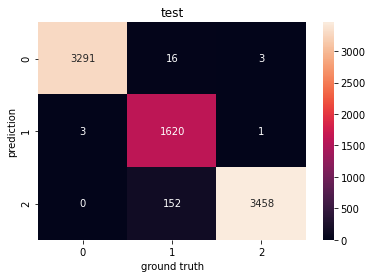

In [18]:
test_loader = DataLoader(train_set, batch_size=50, collate_fn=create_mini_batch)
%time x, y = test(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(num_labels)]))
draw_c_matrix(confusion_matrix(x, y))

In [19]:
# test_loader = DataLoader(amazon_20201210_test_set, batch_size=50, collate_fn=create_mini_batch)
# %time x, y = test(test_loader)
# print(classification_report(x, y, target_names=[str(i) for i in range(num_labels)]))
# draw_c_matrix(confusion_matrix(x, y))

Wall time: 6.09 s
              precision    recall  f1-score   support

           0       0.79      0.70      0.74       912
           1       0.28      0.55      0.37       389
           2       0.90      0.63      0.74       909

    accuracy                           0.64      2210
   macro avg       0.66      0.62      0.62      2210
weighted avg       0.74      0.64      0.67      2210



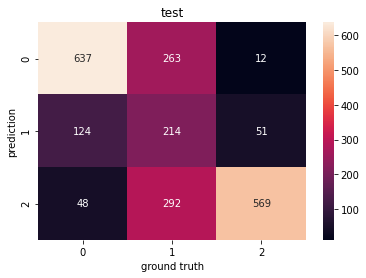

In [20]:
test_loader = DataLoader(sst5_test_set, batch_size=50, collate_fn=create_mini_batch, shuffle = True)
%time x, y = test(test_loader)
print(classification_report(x, y, target_names=[str(i) for i in range(num_labels)]))
draw_c_matrix(confusion_matrix(x, y))